In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random
np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [4]:
DATA_DIR = '/content/drive/MyDrive/sign_prediction_new/sign_dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Validation')

In [23]:
IMG_SIZE = 64
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['4', '17', '9', '0', '35', '3', '10', '20', '32', '7', '24', '16', '14', '8', '33', '37', '34', '19', '27', '15', '28', '13', '22', '31', '29', '25', '11', '30', '1', '2', '6', '21', '26', '23', '5', '18', '36', '12']


In [6]:
classes = len(CATEGORIES)

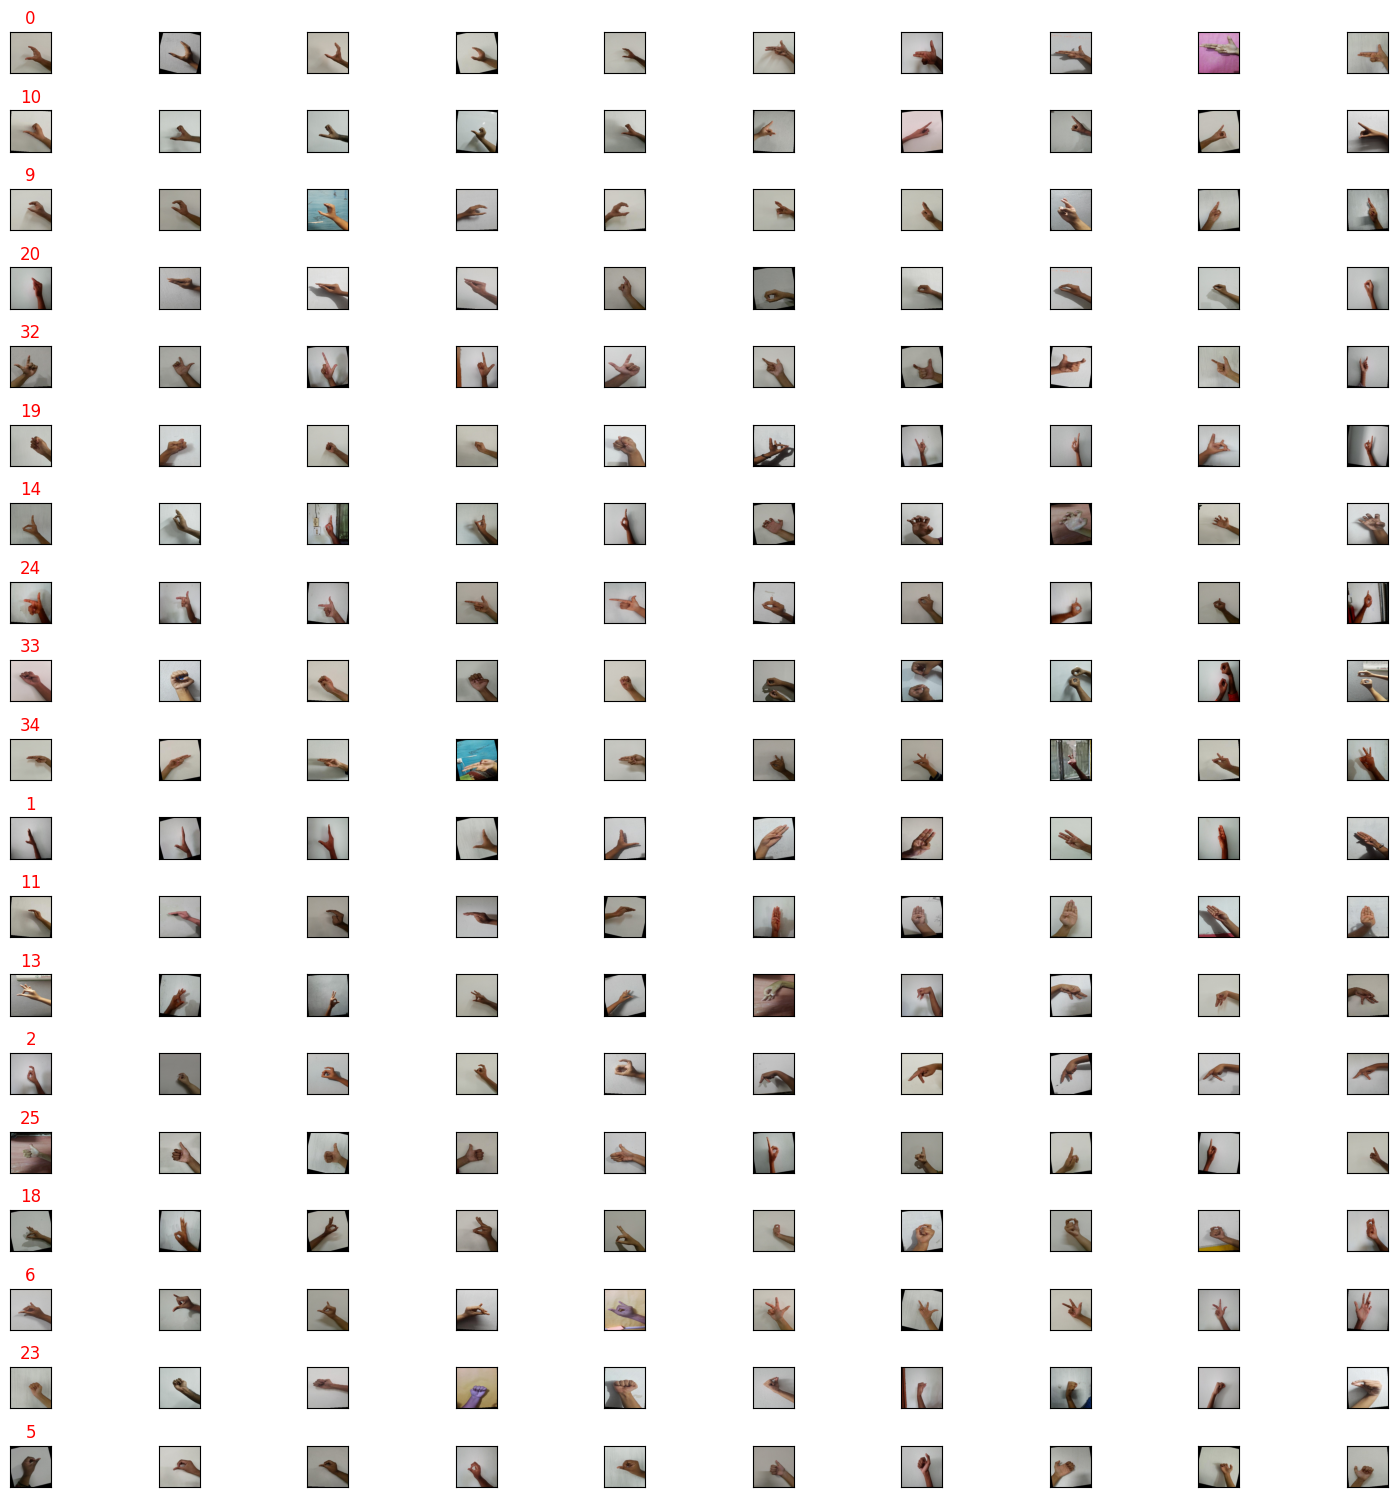

In [ ]:
plt.figure(figsize=(15, 30), facecolor='white')
i = 1
num_images_per_class = 5

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array

        plt.subplot(38, 10, i)
        plt.imshow(white_background)

        if i % 10 == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

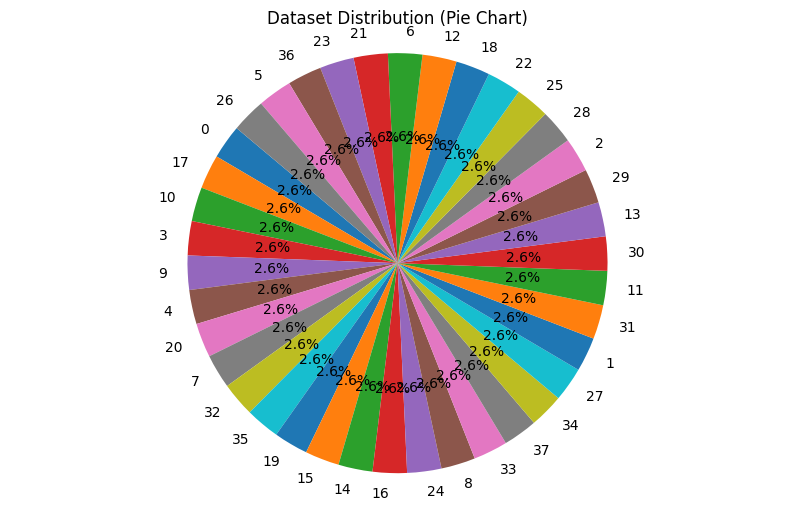

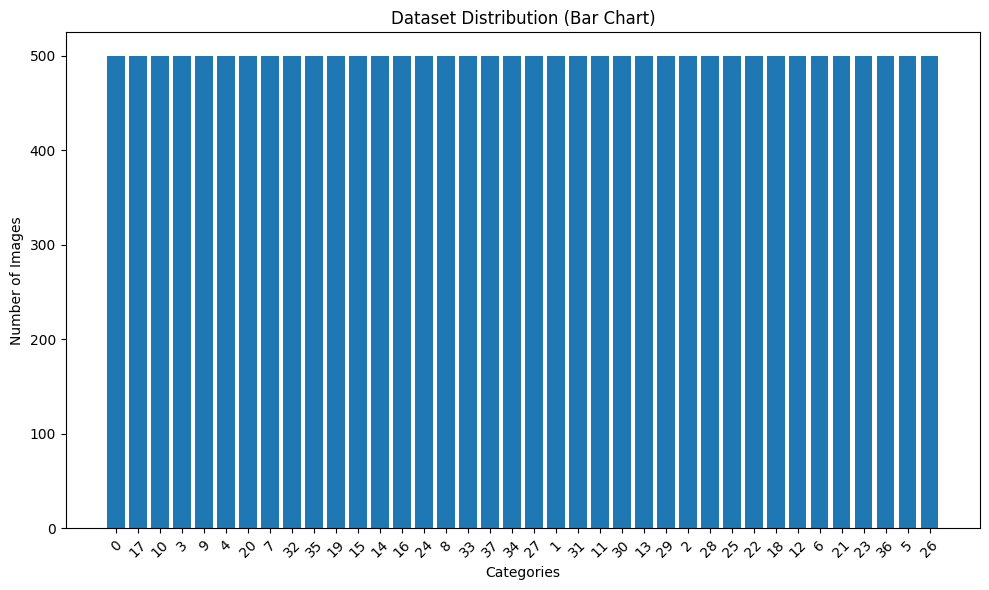

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 500/500 [00:06<00:00, 78.08it/s] 

19000


In [8]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 200/200 [00:03<00:00, 51.95it/s] 

7598


In [9]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (19000, 64, 64, 3) Y_train= (19000,)


In [10]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (7598, 64, 64, 3) Y_test= (7598,)


Efficientnet


In [ ]:
# !pip install -q efficientnet

### Enet B0

In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB0(
    input_shape=(64, 64, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0= tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b0.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
efficientnet_b0 = e_model_b0.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 65s 88ms/step - loss: 2.3402 - accuracy: 0.4049 - val_loss: 0.6919 - val_accuracy: 0.7786
Epoch 2/100
297/297 [==============================] - 20s 67ms/step - loss: 0.7659 - accuracy: 0.7659 - val_loss: 0.3217 - val_accuracy: 0.8996
Epoch 3/100
297/297 [==============================] - 21s 71ms/step - loss: 0.4508 - accuracy: 0.8596 - val_loss: 0.2337 - val_accuracy: 0.9250
Epoch 4/100
297/297 [==============================] - 34s 115ms/step - loss: 0.3227 - accuracy: 0.8989 - val_loss: 0.1765 - val_accuracy: 0.9435
Epoch 5/100
297/297 [==============================] - 30s 100ms/step - loss: 0.2329 - accuracy: 0.9255 - val_loss: 0.1676 - val_accuracy: 0.9479
Epoch 6/100
297/297 [==============================] - 25s 84ms/step - loss: 0.1799 - accuracy: 0.9425 - val_loss: 0.1532 - val_accuracy: 0.9550
Epoch 7/100
297/297 [==============================] - 29s 99ms/step - loss: 0.1536 - accuracy: 0.9515 - val_loss: 0.1798 - val_

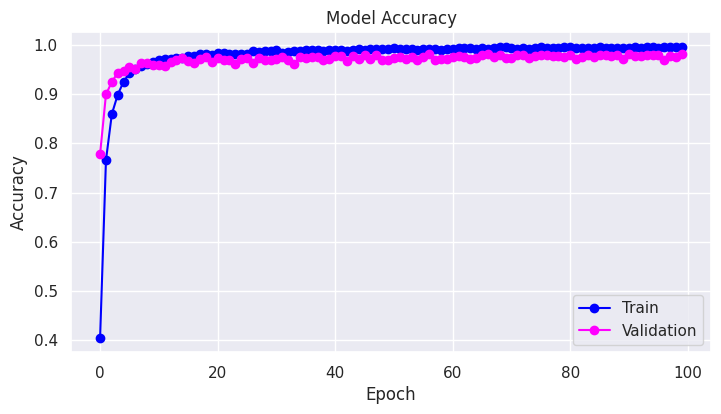

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['accuracy'], 'o-',color="blue")
plt.plot(efficientnet_b0.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

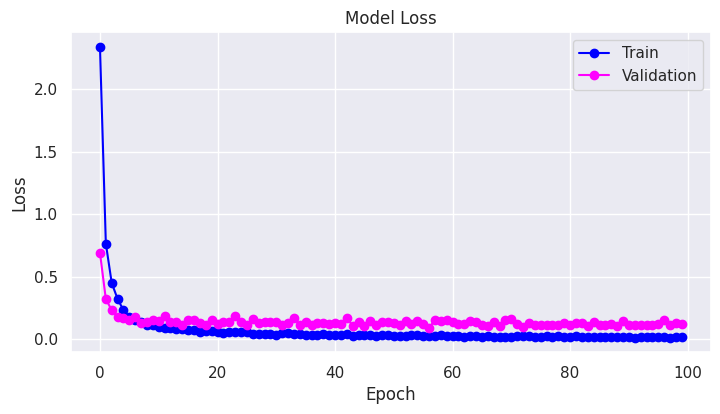

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b0.history['loss'],'o-', color="blue")
plt.plot(efficientnet_b0.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = e_model_b0.evaluate(X_test, Y_test)
train_loss, train_acc=e_model_b0.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 7s 12ms/step - loss: 0.0033 - accuracy: 0.9991

Test Accuracy: 0.9814425110816956

Test Loss: 0.12216593325138092

Train Accuracy: 0.9990526437759399

Train Loss: 0.0033451125491410494


In [ ]:
score = e_model_b0.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  98.144 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b0.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 4s 10ms/step
[ 0  0  0 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[194,   0,   0, ...,   0,   0,   0],
       [  0, 198,   0, ...,   0,   0,   0],
       [  0,   0, 197, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 196,   0,   0],
       [  0,   0,   1, ...,   0, 197,   0],
       [  0,   0,   0, ...,   0,   0, 198]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           0      0.985     0.970     0.977       200
          17      0.990     0.990     0.990       200
          10      0.985     0.985     0.985       200
           3      0.979     0.925     0.951       200
           9      0.985     0.970     0.977       200
           4      0.975     0.975     0.975       200
          20      0.990     0.995     0.993       200
           7      0.985     0.995     0.990       200
          32      1.000     0.980     0.990       200
          35      0.966     0.985     0.975       200
          19      0.980     0.970     0.975       200
          15      0.995     0.975     0.985       199
          14      0.980     0.975     0.977       200
          16      1.000     0.985     0.992       200
          24      0.975     0.975     0.975       200
           8      0.995     0.980     0.987       200
          33      0.917     0.995     0.954       200
          37      1.000    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

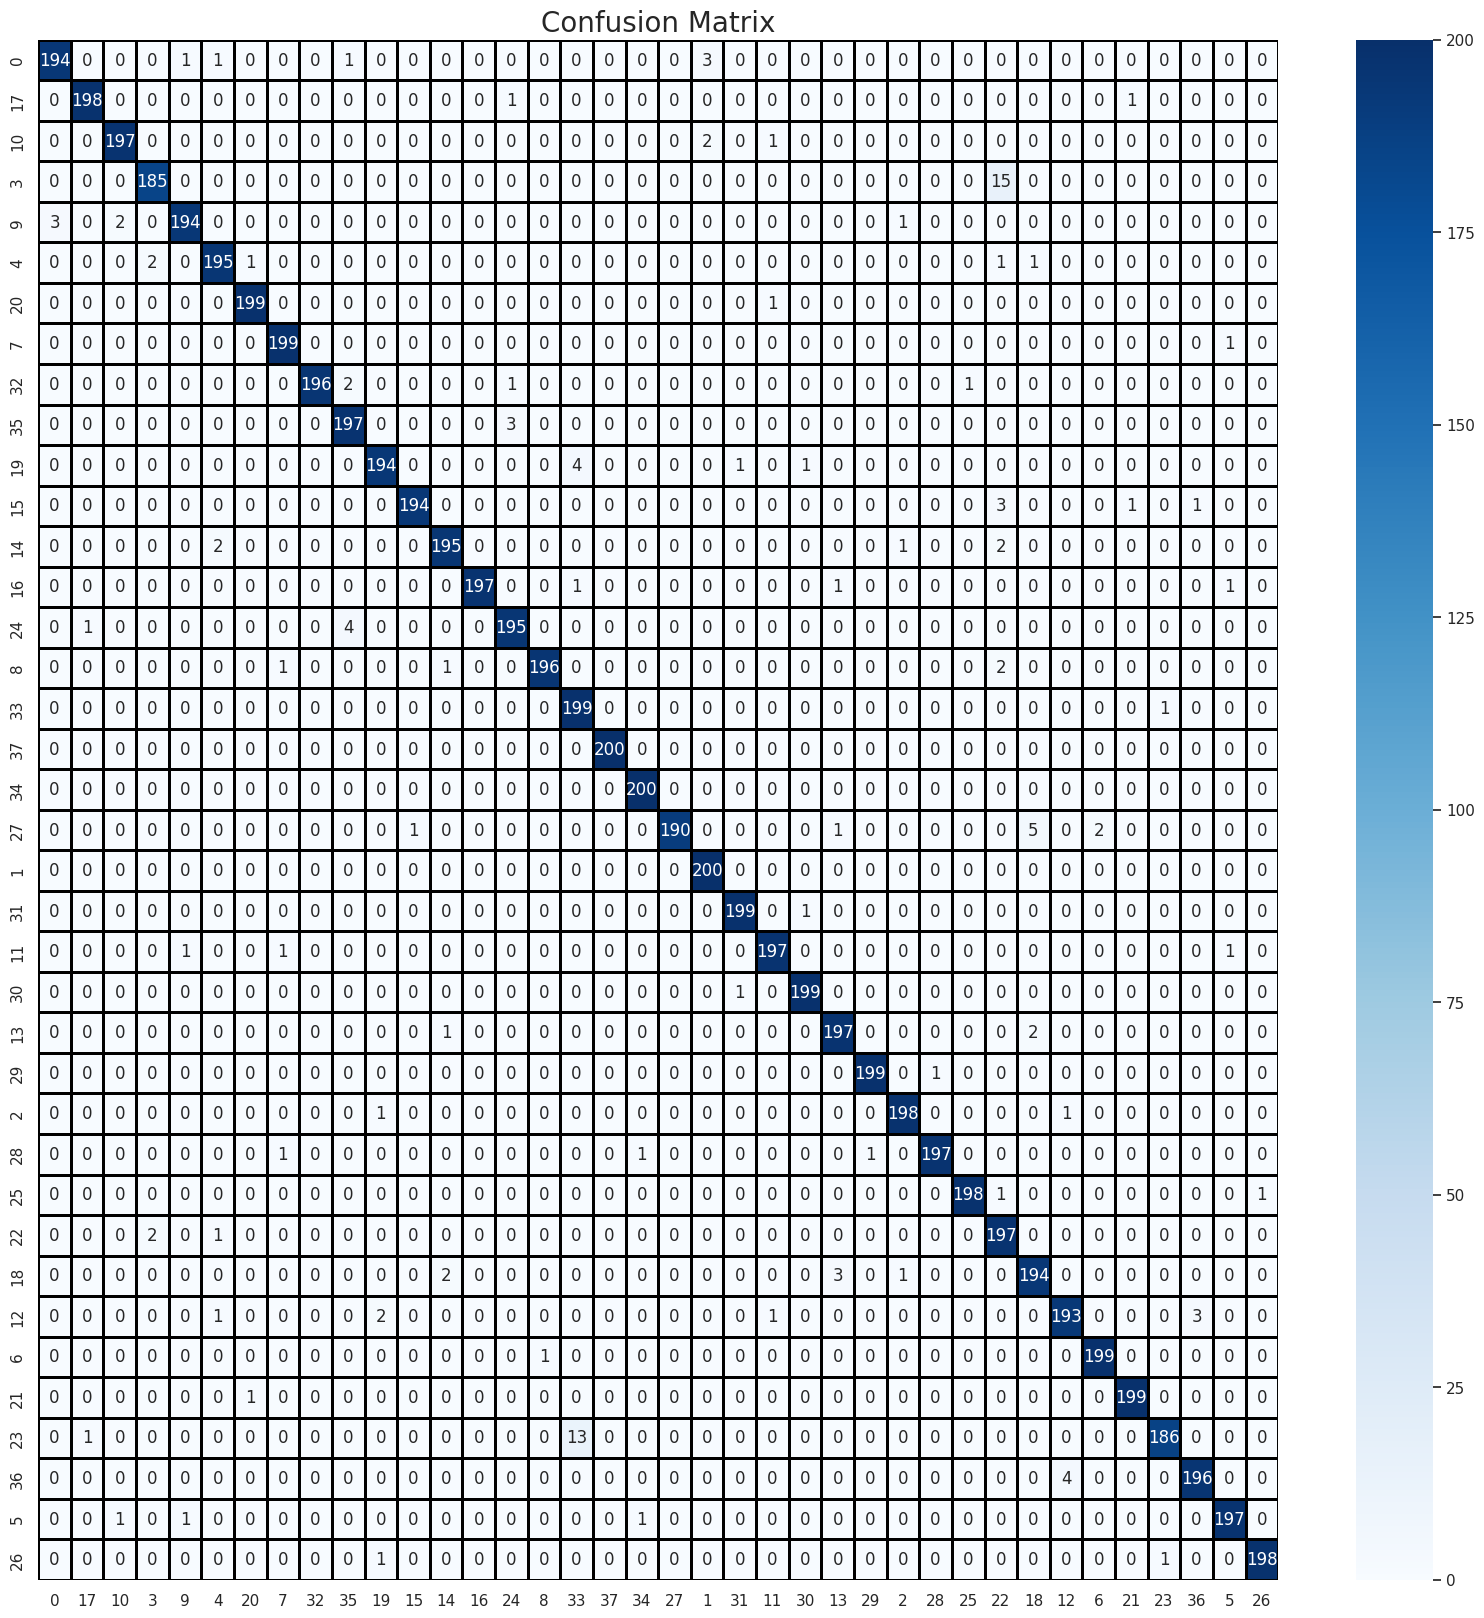

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

238/238 [==============================] - 3s 10ms/step


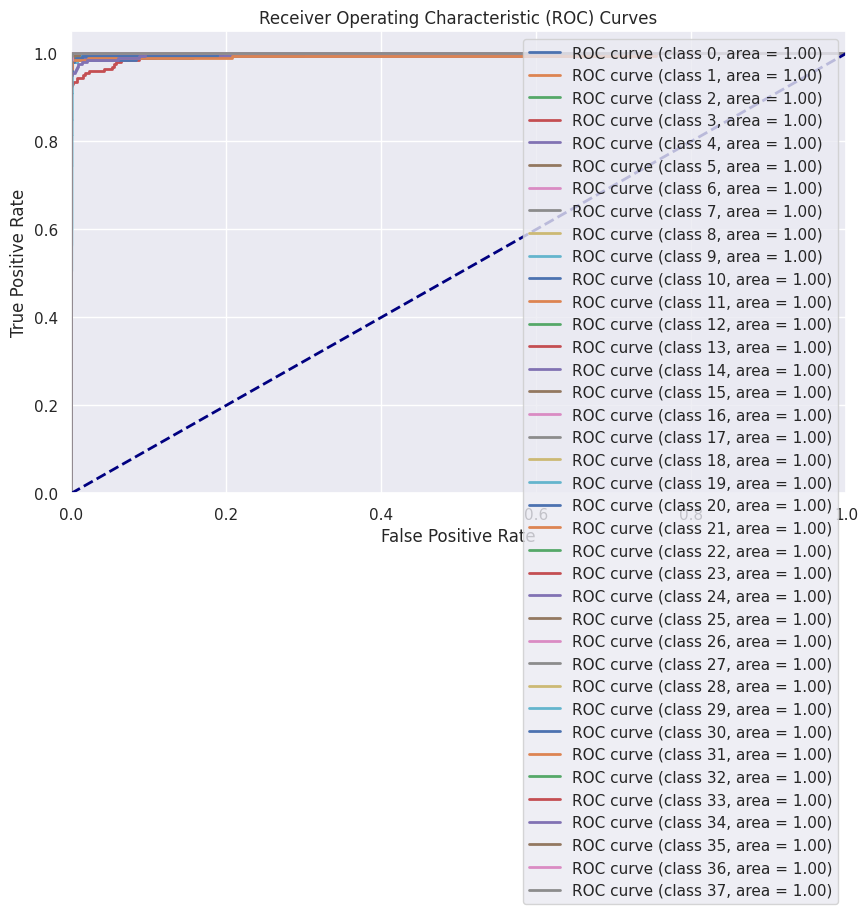

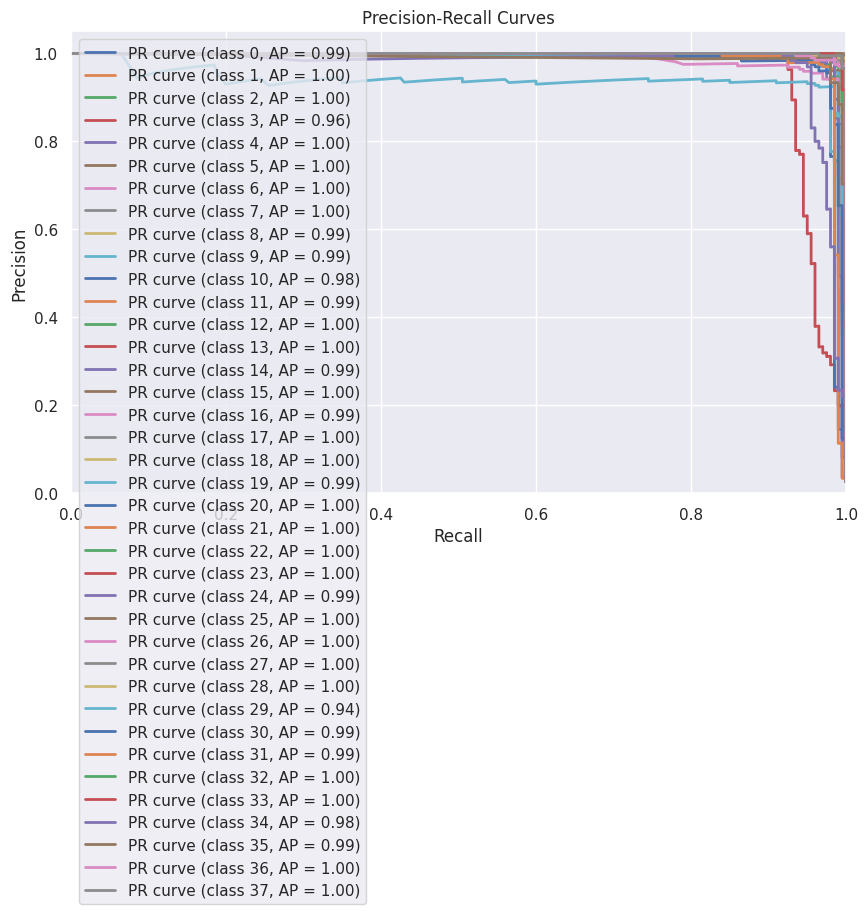

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = e_model_b0.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### Enet B4

In [ ]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB4(
    input_shape=(64, 64, 3),
    weights='imagenet',
    include_top=False
)
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b4= tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
efficientnet_b4 = e_model_b4.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 138s 174ms/step - loss: 3.0792 - accuracy: 0.2522 - val_loss: 1.0606 - val_accuracy: 0.6722
Epoch 2/100
297/297 [==============================] - 43s 144ms/step - loss: 1.0459 - accuracy: 0.6839 - val_loss: 0.3687 - val_accuracy: 0.8819
Epoch 3/100
297/297 [==============================] - 43s 145ms/step - loss: 0.5589 - accuracy: 0.8273 - val_loss: 0.2386 - val_accuracy: 0.9268
Epoch 4/100
297/297 [==============================] - 45s 150ms/step - loss: 0.3723 - accuracy: 0.8861 - val_loss: 0.1797 - val_accuracy: 0.9463
Epoch 5/100
297/297 [==============================] - 43s 144ms/step - loss: 0.2778 - accuracy: 0.9145 - val_loss: 0.1377 - val_accuracy: 0.9592
Epoch 6/100
297/297 [==============================] - 43s 145ms/step - loss: 0.2102 - accuracy: 0.9332 - val_loss: 0.1439 - val_accuracy: 0.9617
Epoch 7/100
297/297 [==============================] - 44s 148ms/step - loss: 0.1671 - accuracy: 0.9500 - val_loss: 0.1110 

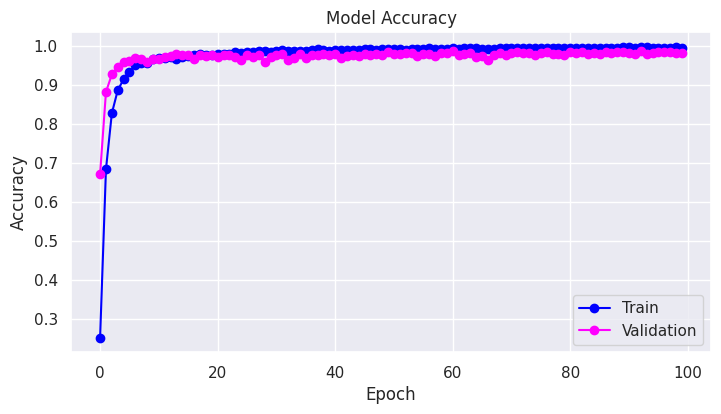

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['accuracy'], 'o-',color="blue")
plt.plot(efficientnet_b4.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

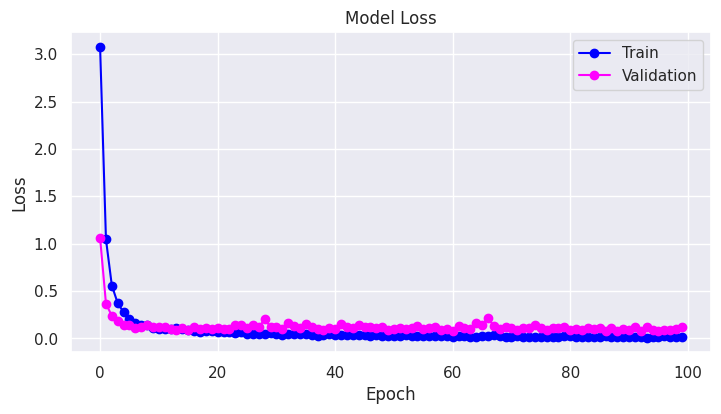

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(efficientnet_b4.history['loss'],'o-', color="blue")
plt.plot(efficientnet_b4.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = e_model_b4.evaluate(X_test, Y_test)
train_loss, train_acc=e_model_b4.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 15s 26ms/step - loss: 0.0090 - accuracy: 0.9976

Test Accuracy: 0.9806528091430664

Test Loss: 0.12018368393182755

Train Accuracy: 0.9975789189338684

Train Loss: 0.00902518630027771


In [ ]:
score = e_model_b4.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  98.065 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b4.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 10s 25ms/step
[ 0  0  0 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[197,   0,   0, ...,   0,   0,   0],
       [  0, 199,   0, ...,   0,   0,   0],
       [  1,   0, 195, ...,   0,   2,   0],
       ...,
       [  0,   0,   0, ..., 198,   0,   0],
       [  0,   0,   1, ...,   0, 196,   0],
       [  0,   1,   0, ...,   0,   0, 192]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           0      0.970     0.985     0.978       200
          17      0.995     0.995     0.995       200
          10      0.985     0.975     0.980       200
           3      0.973     0.905     0.938       200
           9      0.956     0.985     0.970       200
           4      0.980     0.960     0.970       200
          20      0.980     0.995     0.988       200
           7      0.995     0.990     0.992       200
          32      0.990     0.990     0.990       200
          35      0.975     0.990     0.983       200
          19      0.970     0.985     0.978       200
          15      1.000     0.980     0.990       199
          14      0.975     0.985     0.980       200
          16      0.995     0.985     0.990       200
          24      0.990     0.970     0.980       200
           8      1.000     0.985     0.992       200
          33      0.935     1.000     0.966       200
          37      1.000    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

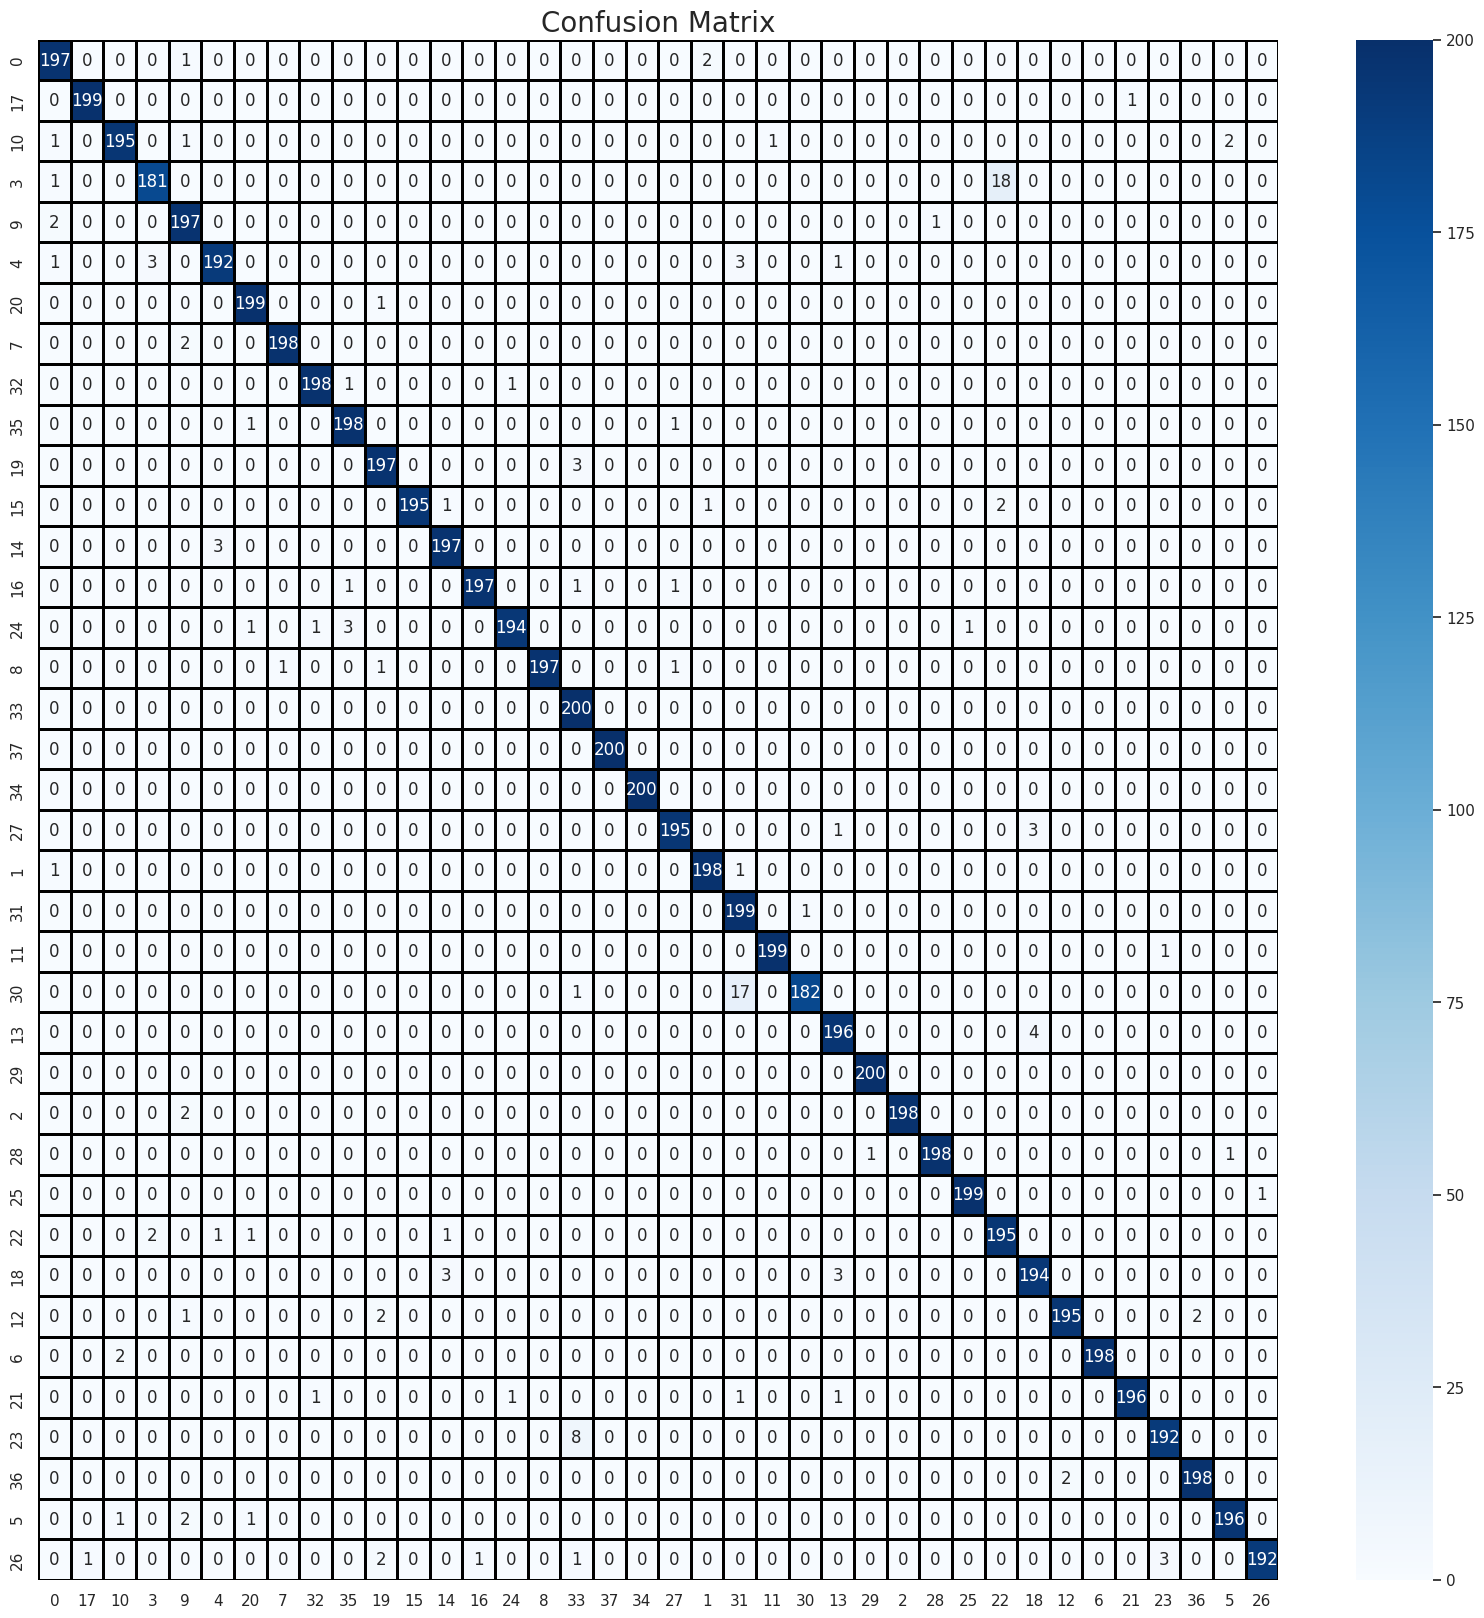

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

238/238 [==============================] - 6s 24ms/step


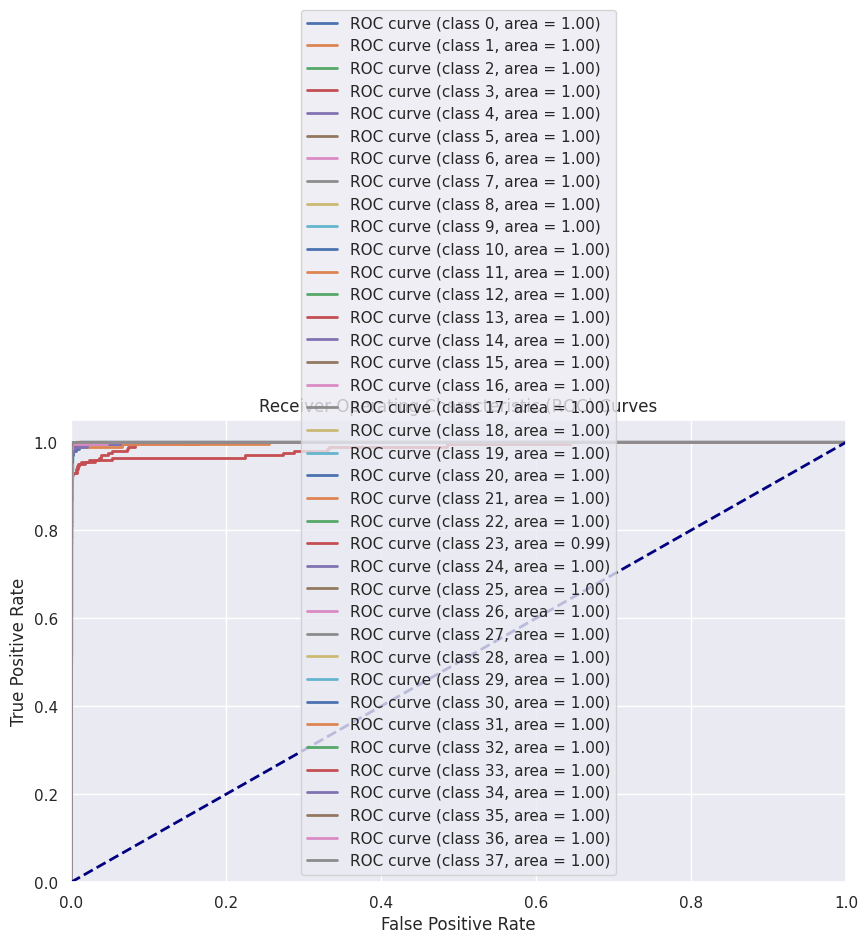

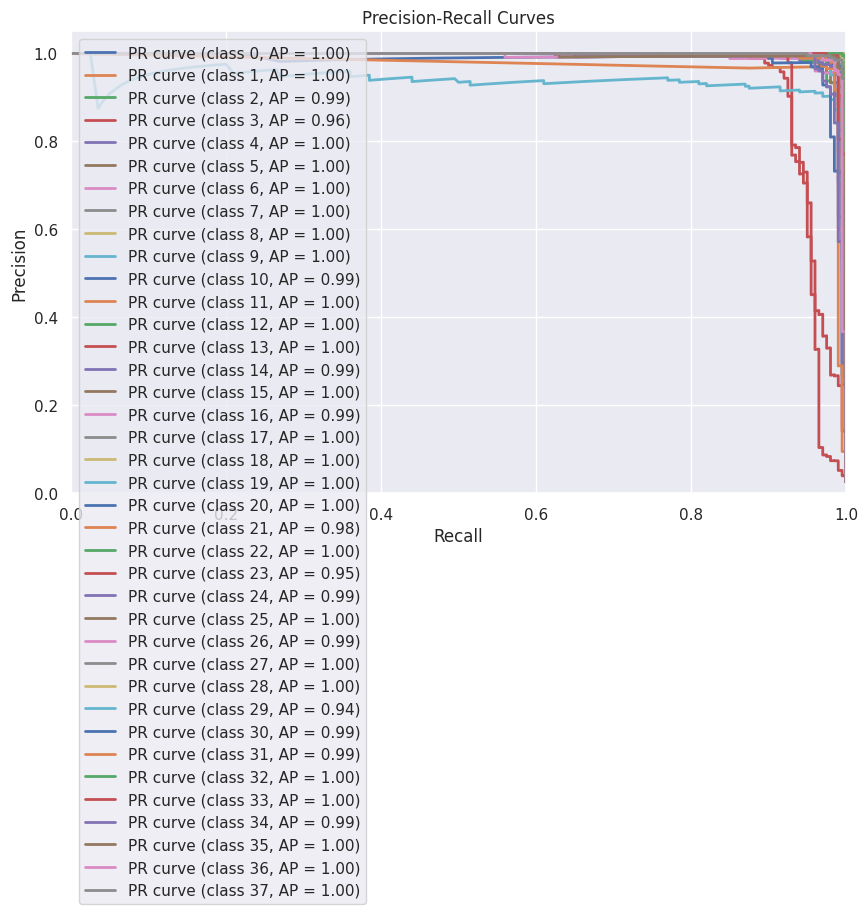

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = e_model_b4.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()


Basic CNN

In [ ]:
bcnn_model = Sequential()
bcnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(64, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Conv2D(128, (3, 3), activation='relu'))
bcnn_model.add(MaxPooling2D((2, 2)))
bcnn_model.add(Flatten())
bcnn_model.add(Dense(512, activation='relu'))
bcnn_model.add(Dropout(0.5))
bcnn_model.add(Dense(classes, activation='softmax'))

In [ ]:
bcnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bcnn = bcnn_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 9s 18ms/step - loss: 3.1161 - accuracy: 0.1612 - val_loss: 1.9572 - val_accuracy: 0.4583
Epoch 2/100
297/297 [==============================] - 4s 13ms/step - loss: 1.9176 - accuracy: 0.4384 - val_loss: 1.1285 - val_accuracy: 0.6857
Epoch 3/100
297/297 [==============================] - 4s 13ms/step - loss: 1.3665 - accuracy: 0.5881 - val_loss: 0.8159 - val_accuracy: 0.7672
Epoch 4/100
297/297 [==============================] - 4s 12ms/step - loss: 1.0648 - accuracy: 0.6710 - val_loss: 0.6485 - val_accuracy: 0.8085
Epoch 5/100
297/297 [==============================] - 3s 12ms/step - loss: 0.9017 - accuracy: 0.7174 - val_loss: 0.5289 - val_accuracy: 0.8493
Epoch 6/100
297/297 [==============================] - 4s 13ms/step - loss: 0.7597 - accuracy: 0.7558 - val_loss: 0.4608 - val_accuracy: 0.8680
Epoch 7/100
297/297 [==============================] - 5s 16ms/step - loss: 0.6395 - accuracy: 0.7928 - val_loss: 0.4136 - val_accuracy:

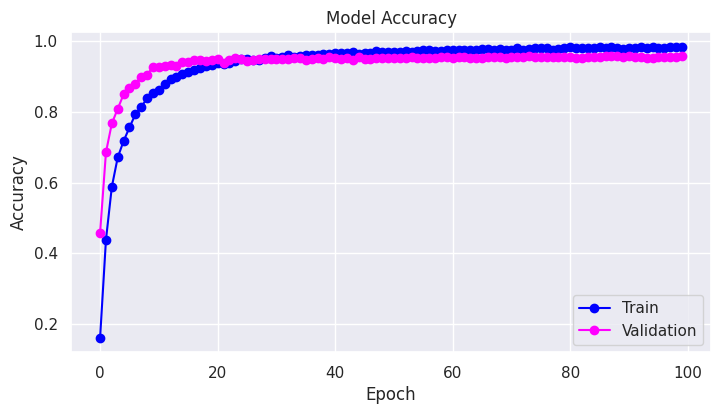

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['accuracy'], 'o-',color="blue")
plt.plot(bcnn.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

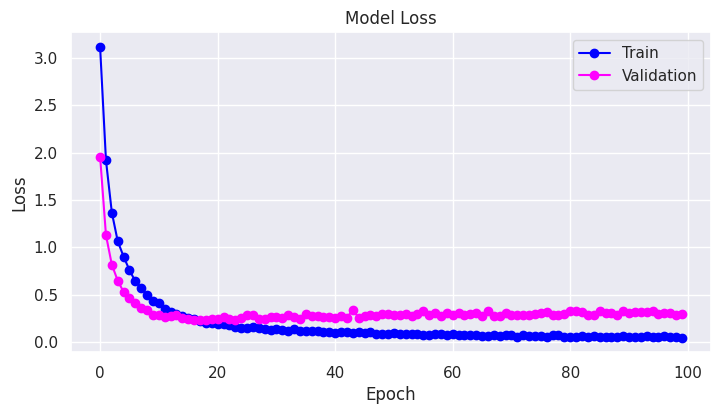

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(bcnn.history['loss'],'o-', color="blue")
plt.plot(bcnn.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = bcnn_model.evaluate(X_test, Y_test)
train_loss, train_acc=bcnn_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 3s 5ms/step - loss: 4.8813e-04 - accuracy: 0.9999

Test Accuracy: 0.9572255611419678

Test Loss: 0.2912798225879669

Train Accuracy: 0.9999473690986633

Train Loss: 0.000488131568999961


In [ ]:
score = bcnn_model.evaluate(X_test,Y_test,verbose=0)
print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  95.723 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(bcnn_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 1s 3ms/step
[ 0 19  0 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[189,   0,   0, ...,   0,   0,   0],
       [  0, 196,   0, ...,   0,   0,   0],
       [  0,   1, 191, ...,   0,   3,   1],
       ...,
       [  0,   0,   0, ..., 193,   0,   0],
       [  0,   0,   1, ...,   0, 195,   0],
       [  0,   1,   0, ...,   0,   0, 188]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           0      0.964     0.945     0.955       200
          17      0.980     0.980     0.980       200
          10      0.974     0.955     0.965       200
           3      0.944     0.920     0.932       200
           9      0.990     0.960     0.975       200
           4      0.935     0.940     0.938       200
          20      0.990     0.950     0.969       200
           7      0.965     0.960     0.962       200
          32      0.985     0.965     0.975       200
          35      0.932     0.960     0.946       200
          19      0.927     0.950     0.938       200
          15      0.953     0.915     0.933       199
          14      0.921     0.930     0.925       200
          16      0.951     0.965     0.958       200
          24      0.960     0.950     0.955       200
           8      0.979     0.955     0.967       200
          33      0.936     0.955     0.946       200
          37      0.980    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

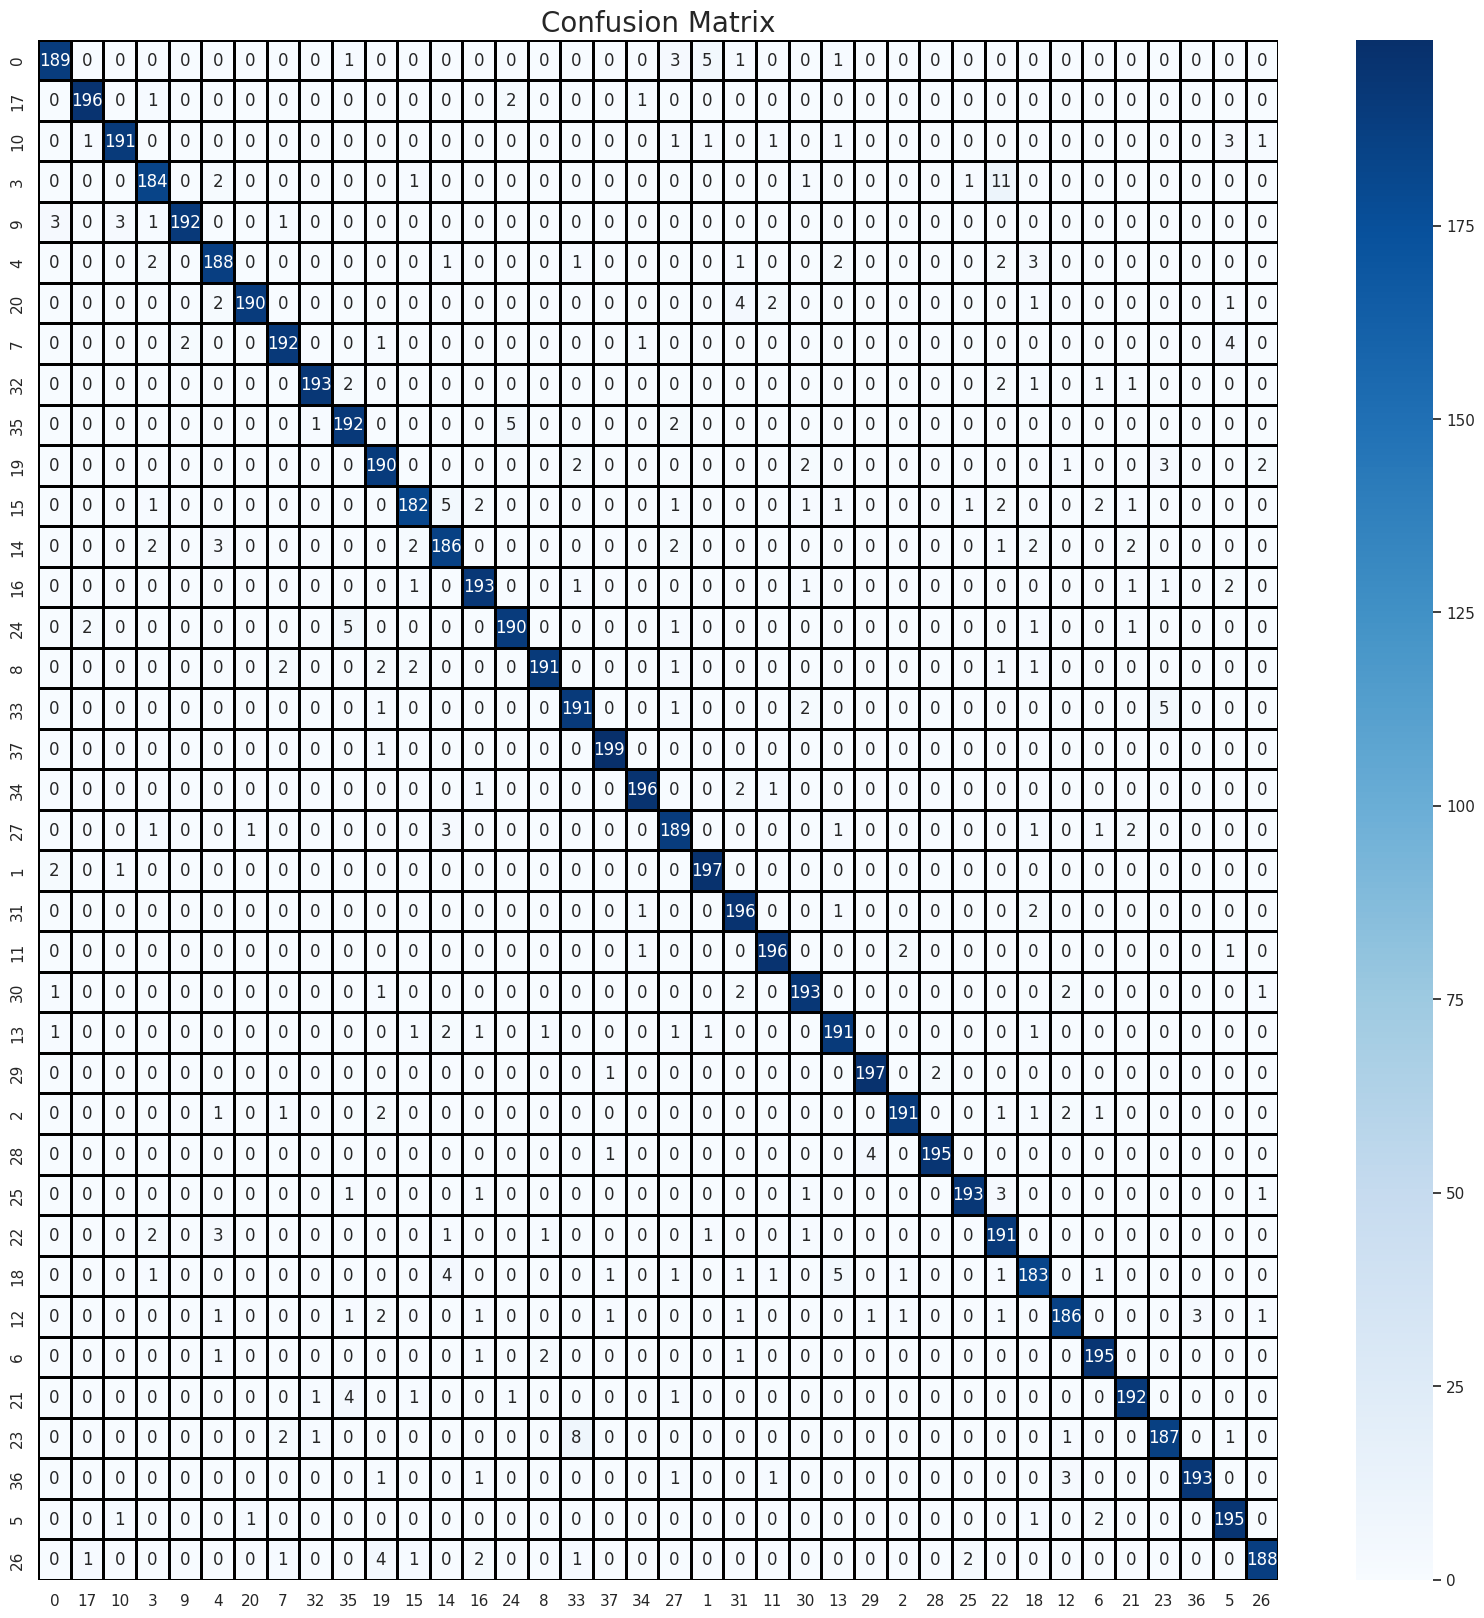

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

238/238 [==============================] - 1s 3ms/step


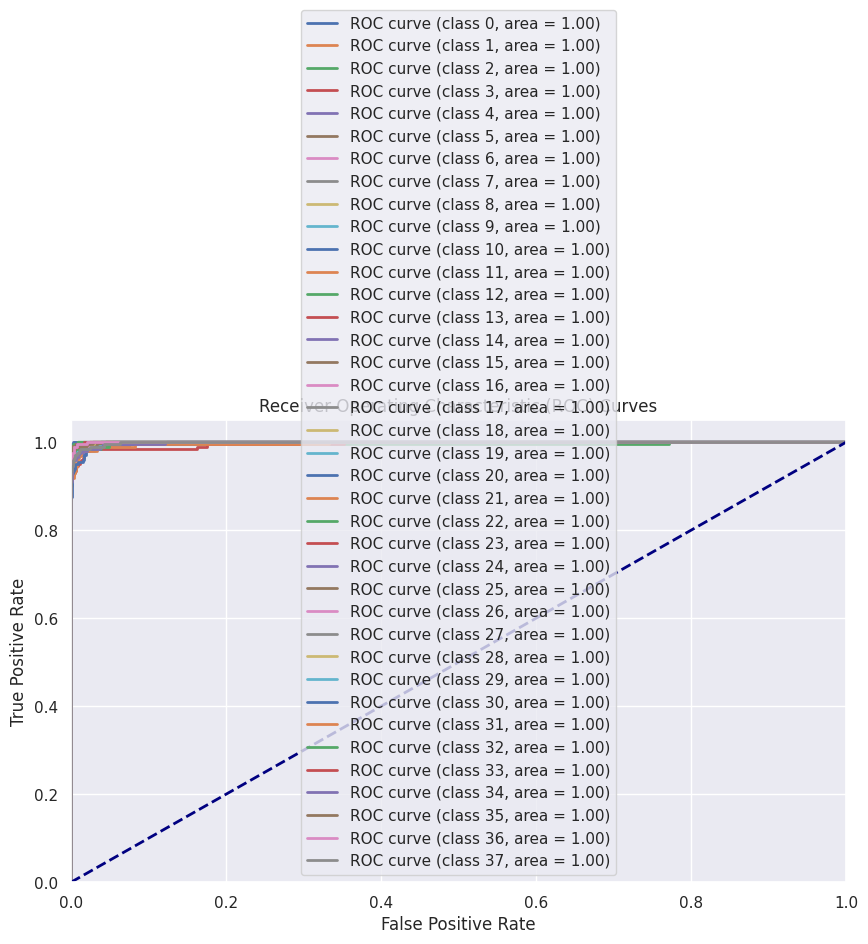

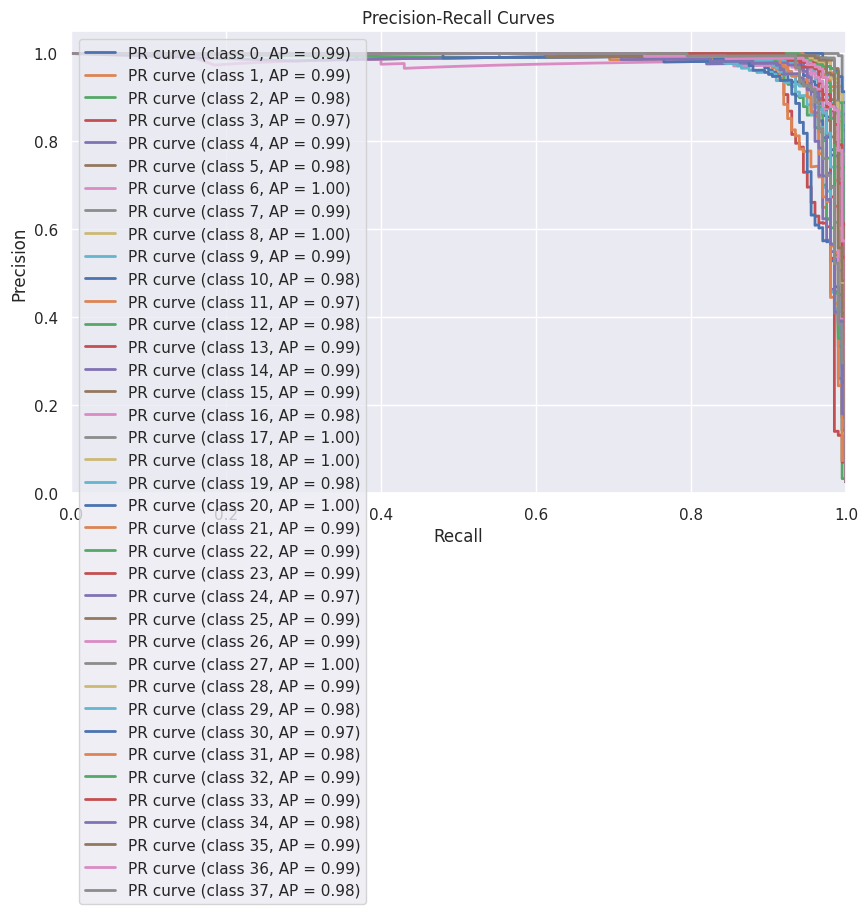

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = bcnn_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

VGG19

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam

VGG19_basic_model = VGG19(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# Freeze all layers of the pre-trained model
for layer in VGG19_basic_model.layers:
    layer.trainable = False
VGG19_model = Sequential()
VGG19_model.add(VGG19_basic_model)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dense(classes, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
VGG19_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
VGG19_pretrained = VGG19_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 18s 51ms/step - loss: 2.6537 - accuracy: 0.2915 - val_loss: 1.8552 - val_accuracy: 0.4766
Epoch 2/100
297/297 [==============================] - 13s 42ms/step - loss: 1.7807 - accuracy: 0.4956 - val_loss: 1.4521 - val_accuracy: 0.5723
Epoch 3/100
297/297 [==============================] - 12s 42ms/step - loss: 1.4953 - accuracy: 0.5706 - val_loss: 1.3156 - val_accuracy: 0.6024
Epoch 4/100
297/297 [==============================] - 13s 42ms/step - loss: 1.3301 - accuracy: 0.6112 - val_loss: 1.1484 - val_accuracy: 0.6485
Epoch 5/100
297/297 [==============================] - 12s 42ms/step - loss: 1.2199 - accuracy: 0.6428 - val_loss: 1.0424 - val_accuracy: 0.6868
Epoch 6/100
297/297 [==============================] - 14s 48ms/step - loss: 1.1265 - accuracy: 0.6669 - val_loss: 1.0281 - val_accuracy: 0.6816
Epoch 7/100
297/297 [==============================] - 14s 47ms/step - loss: 1.0608 - accuracy: 0.6801 - val_loss: 0.9409 - val_ac

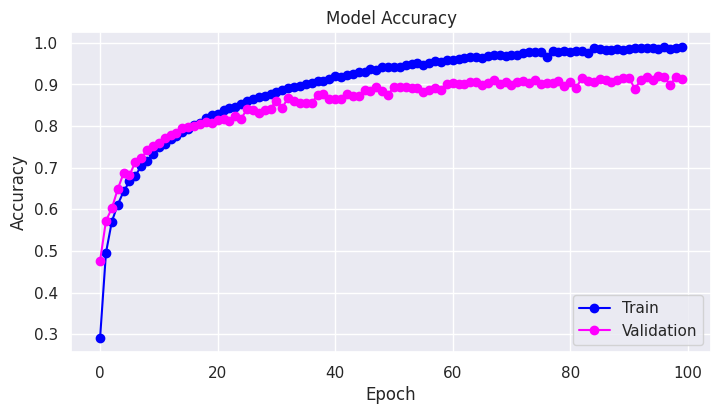

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(VGG19_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

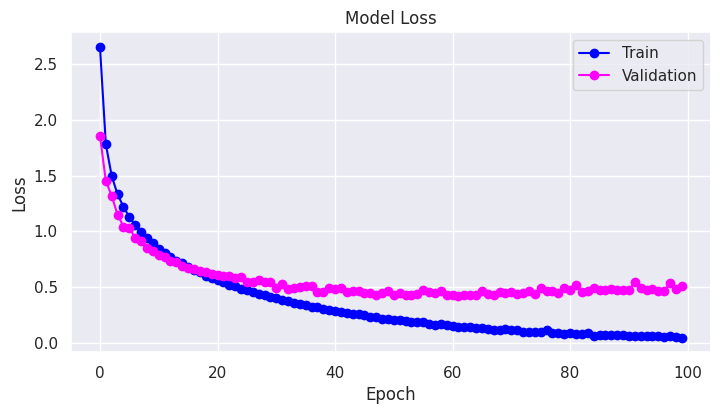

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['loss'],'o-', color="blue")
plt.plot(VGG19_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = VGG19_model.evaluate(X_test, Y_test)
train_loss, train_acc=VGG19_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 12s 20ms/step - loss: 0.0569 - accuracy: 0.9855

Test Accuracy: 0.9120821356773376

Test Loss: 0.5071194767951965

Train Accuracy: 0.9855263233184814

Train Loss: 0.05686591565608978


In [ ]:
score = VGG19_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  91.208 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(VGG19_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 4s 17ms/step
[ 5 19  3 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[176,   0,   0, ...,   0,   0,   0],
       [  1, 184,   0, ...,   0,   0,   0],
       [  1,   0, 185, ...,   0,   0,   0],
       ...,
       [  2,   0,   0, ..., 152,   0,   0],
       [  0,   0,   0, ...,   0, 190,   5],
       [  0,   0,   0, ...,   0,   3, 173]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           4      0.898     0.880     0.889       200
          17      0.979     0.920     0.948       200
           9      0.885     0.925     0.905       200
           0      0.874     0.970     0.919       200
          35      0.954     0.930     0.942       200
           3      0.929     0.855     0.891       200
          10      0.891     0.940     0.915       200
          20      0.970     0.975     0.973       200
          32      0.984     0.900     0.940       200
           7      0.962     0.890     0.925       200
          24      0.912     0.935     0.923       200
          16      0.893     0.955     0.923       200
          14      0.832     0.915     0.871       200
           8      0.942     0.900     0.921       200
          33      0.906     0.820     0.861       200
          37      0.970     0.980     0.975       200
          34      0.984     0.935     0.959       200
          19      0.893    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

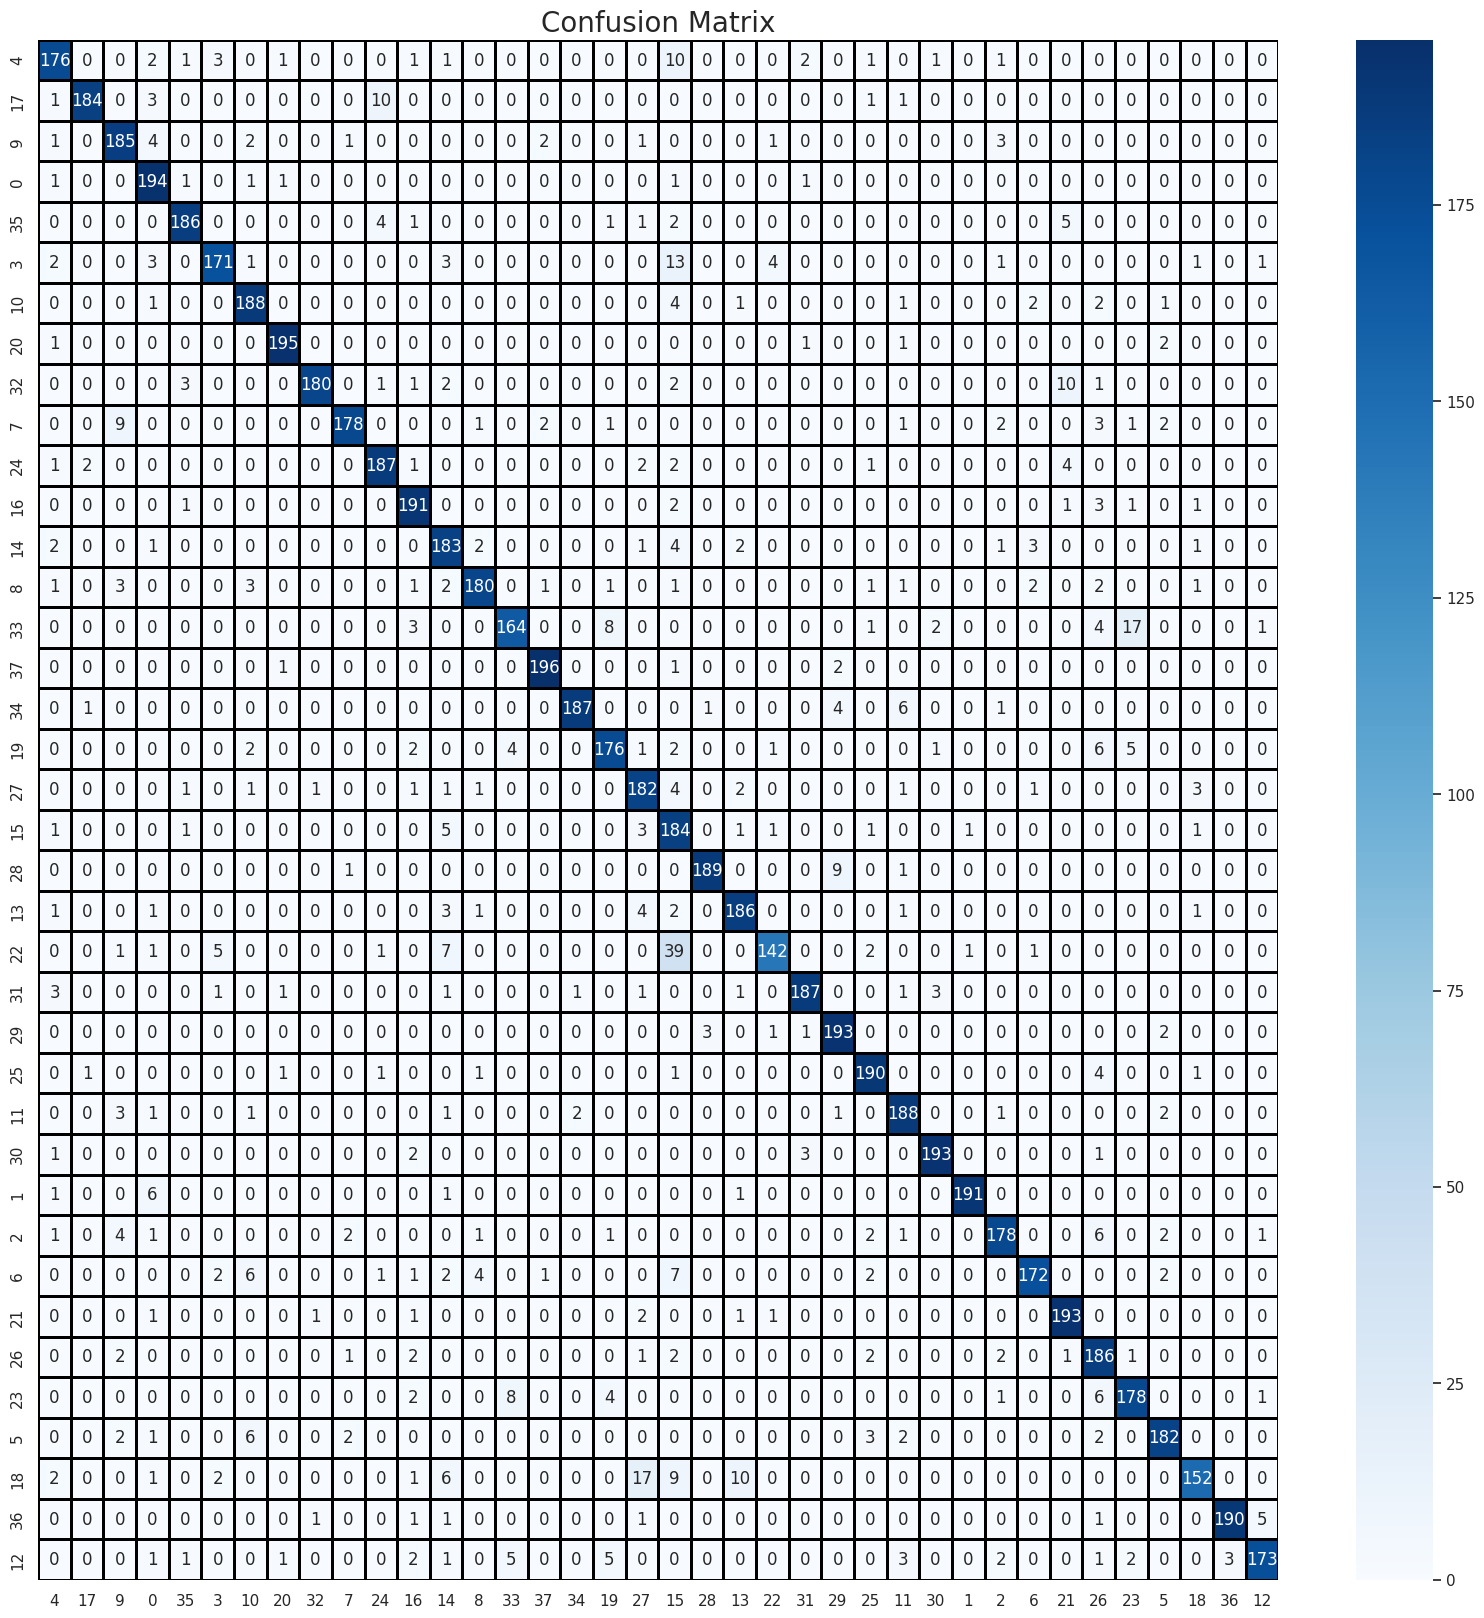

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 18ms/step


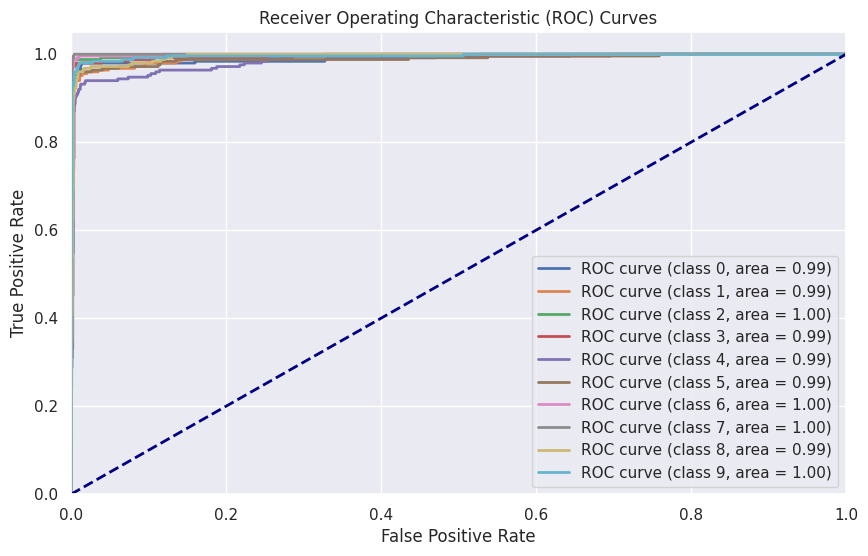

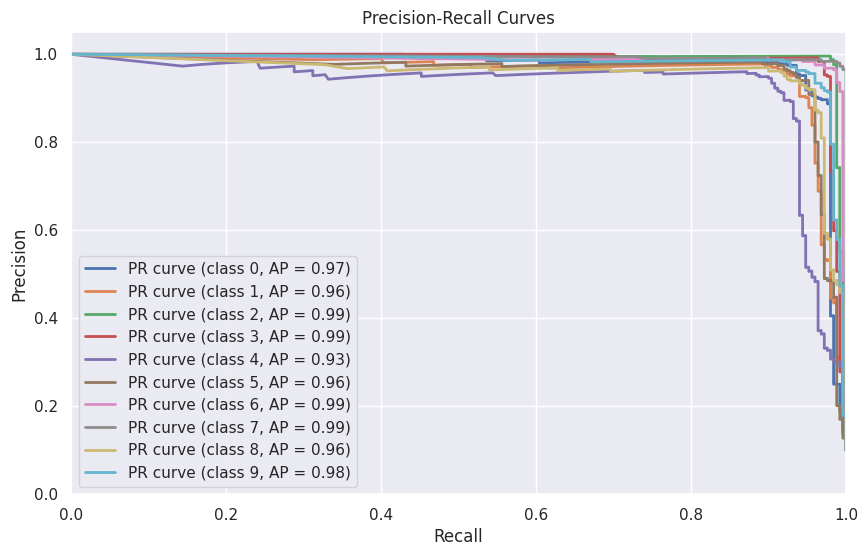

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = VGG19_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model with pre-trained weights (include_top=False for feature extraction)
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of the pre-trained model
for layer in DenseNet121_model.layers:
    layer.trainable = False

# Create a new Sequential model
DenseNet121_custom_model = Sequential()
DenseNet121_custom_model.add(DenseNet121_model)
DenseNet121_custom_model.add(Flatten())
DenseNet121_custom_model.add(Dense(128, activation='relu'))
DenseNet121_custom_model.add(Dense(38, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
DenseNet121_custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
DenseNet121_pretrained = DenseNet121_custom_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 82s 250ms/step - loss: 2.7033 - accuracy: 0.2621 - val_loss: 1.6261 - val_accuracy: 0.5028
Epoch 2/100
297/297 [==============================] - 15s 50ms/step - loss: 1.6943 - accuracy: 0.4874 - val_loss: 1.3586 - val_accuracy: 0.5802
Epoch 3/100
297/297 [==============================] - 11s 37ms/step - loss: 1.4605 - accuracy: 0.5488 - val_loss: 1.2014 - val_accuracy: 0.6220
Epoch 4/100
297/297 [==============================] - 13s 43ms/step - loss: 1.3194 - accuracy: 0.5882 - val_loss: 1.1420 - val_accuracy: 0.6346
Epoch 5/100
297/297 [==============================] - 13s 44ms/step - loss: 1.2364 - accuracy: 0.6131 - val_loss: 1.0498 - val_accuracy: 0.6706
Epoch 6/100
297/297 [==============================] - 11s 37ms/step - loss: 1.1818 - accuracy: 0.6293 - val_loss: 1.0545 - val_accuracy: 0.6704
Epoch 7/100
297/297 [==============================] - 11s 38ms/step - loss: 1.1252 - accuracy: 0.6463 - val_loss: 1.0294 - val_a

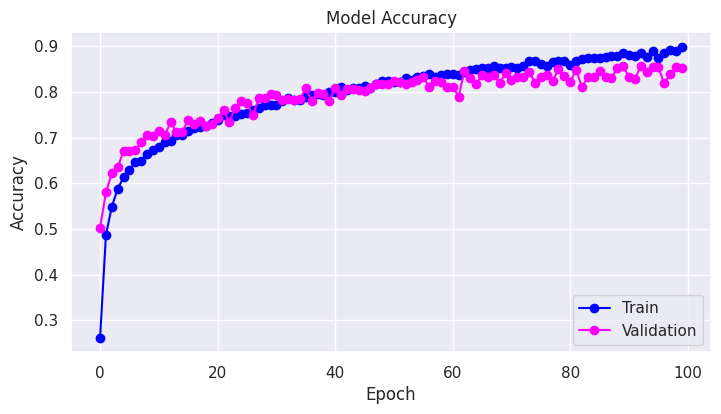

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(DenseNet121_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

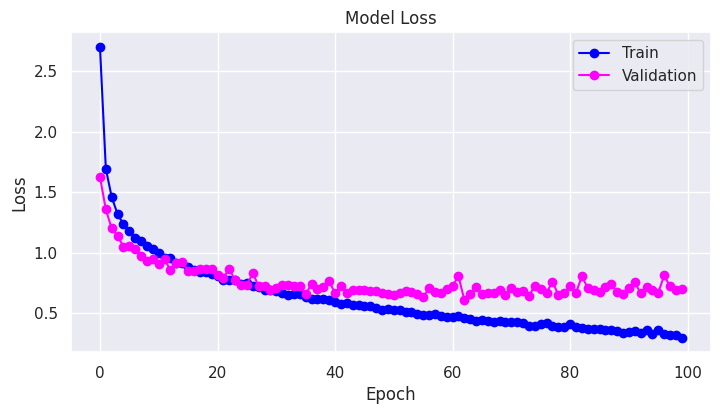

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(DenseNet121_pretrained.history['loss'],'o-', color="blue")
plt.plot(DenseNet121_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = DenseNet121_custom_model.evaluate(X_test, Y_test)
train_loss, train_acc = DenseNet121_custom_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 14s 23ms/step - loss: 0.2818 - accuracy: 0.9039

Test Accuracy: 0.8524611592292786

Test Loss: 0.7043992280960083

Train Accuracy: 0.9038947224617004

Train Loss: 0.28176623582839966


In [ ]:
score = DenseNet121_custom_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  85.246 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(DenseNet121_custom_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 7s 21ms/step
[ 0 35  7 ...  9 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[159,   1,   0, ...,   2,   0,   0],
       [  0, 189,   0, ...,   1,   0,   0],
       [  0,   0, 153, ...,   0,   0,   0],
       ...,
       [  1,   0,   0, ..., 143,   0,   0],
       [  0,   1,   0, ...,   0, 182,   7],
       [  1,   0,   0, ...,   0,   8, 156]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           4      0.914     0.795     0.850       200
          17      0.750     0.945     0.836       200
           9      0.950     0.765     0.848       200
           0      0.912     0.825     0.866       200
          35      0.851     0.825     0.838       200
           3      0.847     0.775     0.809       200
          10      0.771     0.860     0.813       200
          20      0.955     0.855     0.902       200
          32      1.000     0.725     0.841       200
           7      0.878     0.900     0.889       200
          24      0.709     0.830     0.765       200
          16      0.956     0.870     0.911       200
          14      0.880     0.730     0.798       200
           8      0.768     0.875     0.818       200
          33      0.866     0.710     0.780       200
          37      0.980     0.975     0.977       200
          34      0.870     0.970     0.917       200
          19      0.670    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

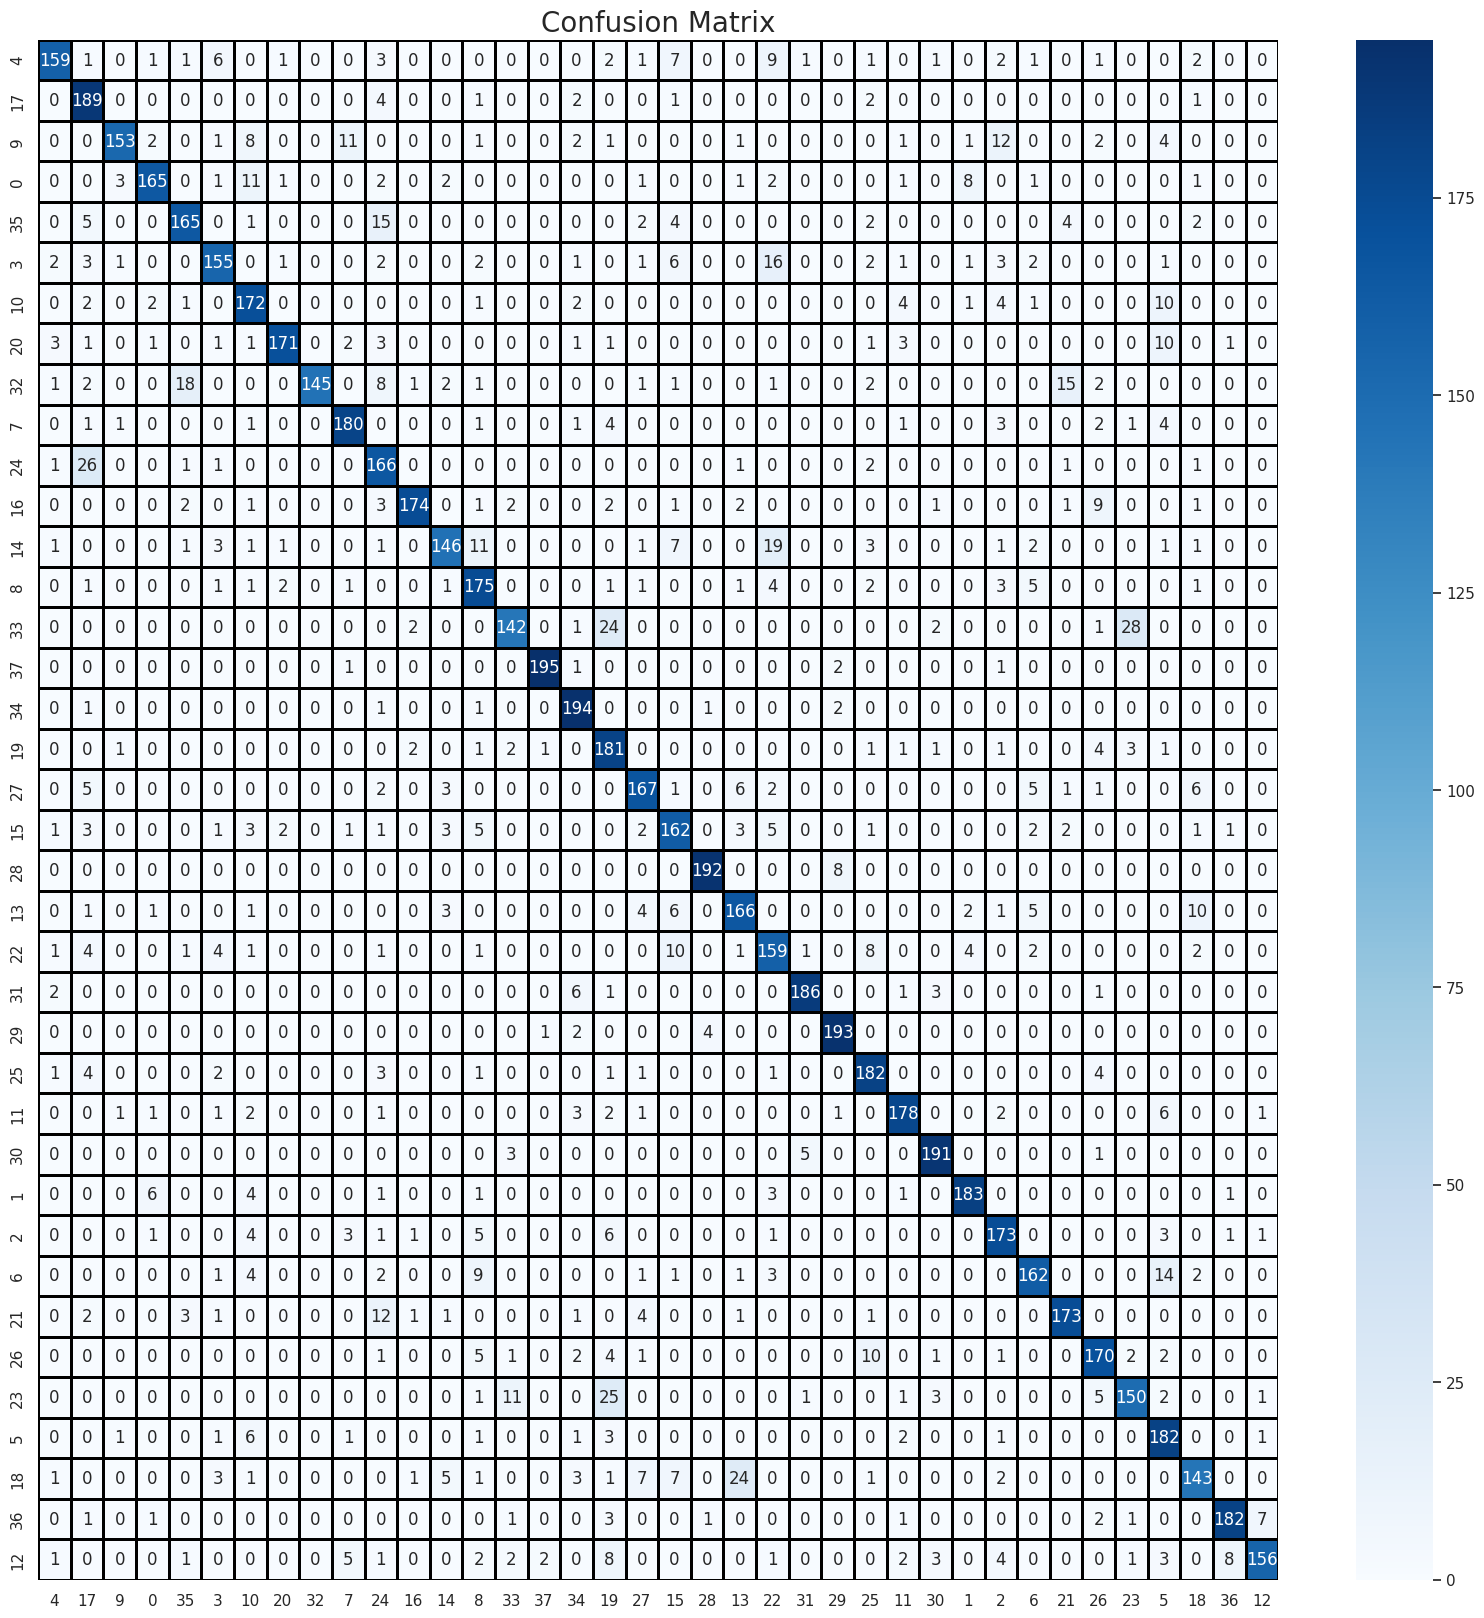

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

238/238 [==============================] - 4s 17ms/step


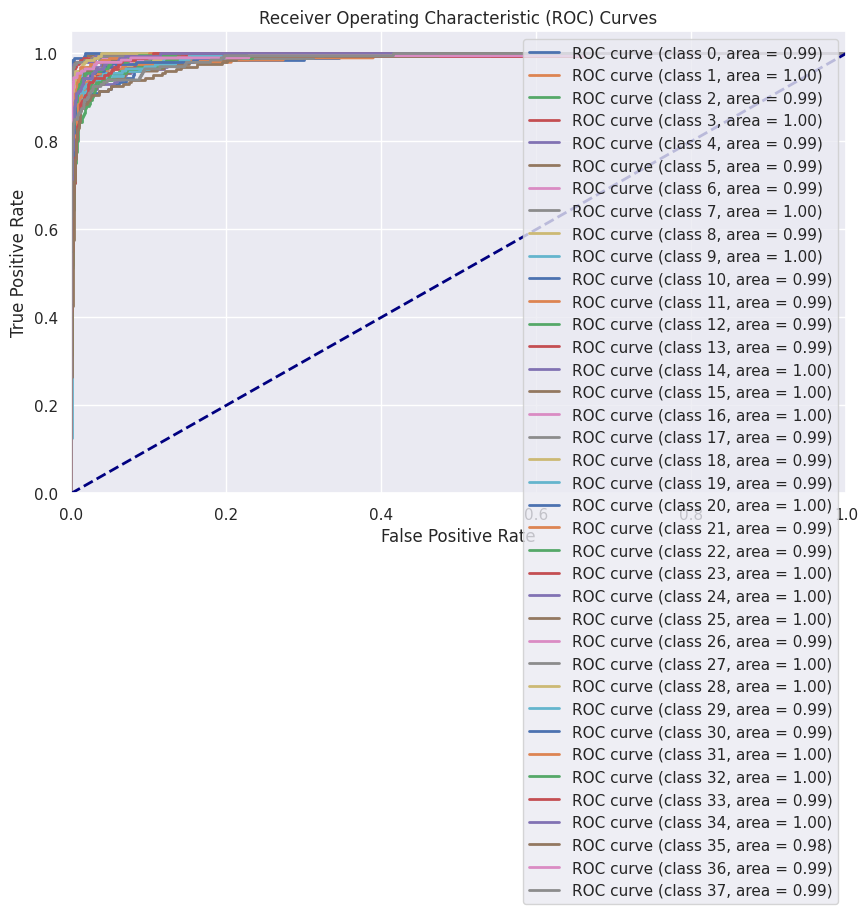

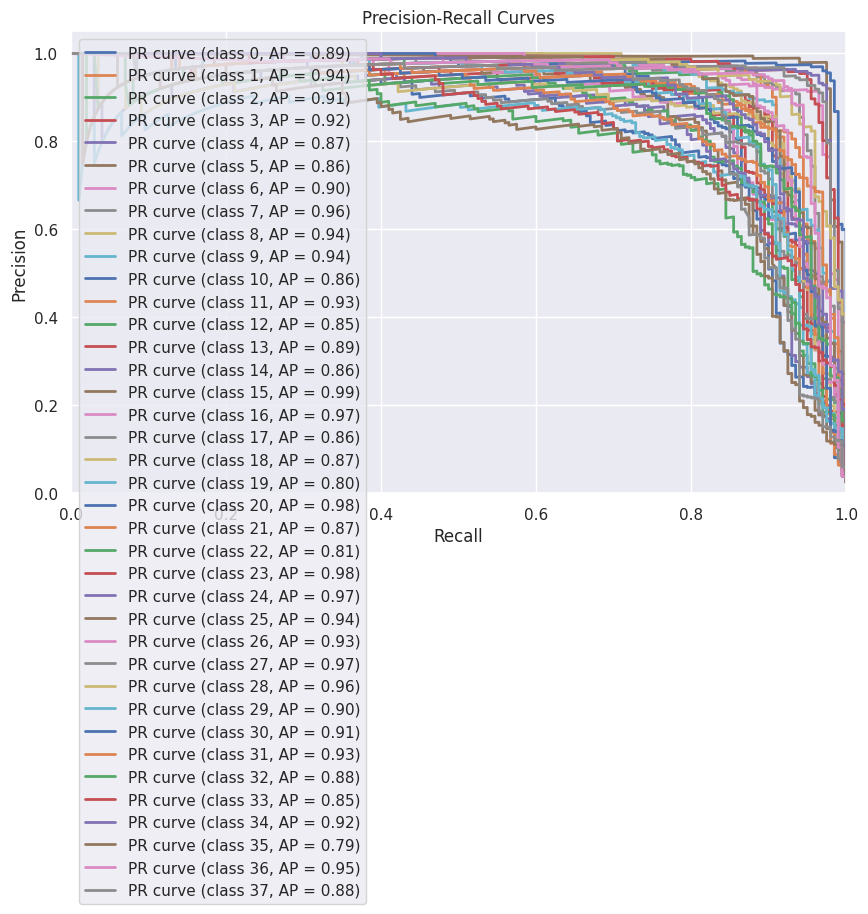

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = DenseNet121_custom_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

**VGG16**

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam

VGG16_basic_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# Freeze all layers of the pre-trained model
for layer in VGG16_basic_model.layers:
    layer.trainable = False
VGG16_model = Sequential()
VGG16_model.add(VGG16_basic_model)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(128, activation='relu'))
VGG16_model.add(Dense(classes, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
VGG16_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG16_pretrained = VGG16_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 22s 47ms/step - loss: 2.4295 - accuracy: 0.3519 - val_loss: 1.6648 - val_accuracy: 0.5296
Epoch 2/100
297/297 [==============================] - 12s 41ms/step - loss: 1.5532 - accuracy: 0.5557 - val_loss: 1.2647 - val_accuracy: 0.6306
Epoch 3/100
297/297 [==============================] - 10s 33ms/step - loss: 1.2763 - accuracy: 0.6285 - val_loss: 1.1207 - val_accuracy: 0.6599
Epoch 4/100
297/297 [==============================] - 10s 34ms/step - loss: 1.1277 - accuracy: 0.6648 - val_loss: 0.9858 - val_accuracy: 0.7022
Epoch 5/100
297/297 [==============================] - 12s 41ms/step - loss: 1.0094 - accuracy: 0.7051 - val_loss: 0.8892 - val_accuracy: 0.7302
Epoch 6/100
297/297 [==============================] - 10s 33ms/step - loss: 0.9239 - accuracy: 0.7242 - val_loss: 0.8463 - val_accuracy: 0.7407
Epoch 7/100
297/297 [==============================] - 13s 43ms/step - loss: 0.8514 - accuracy: 0.7449 - val_loss: 0.7897 - val_ac

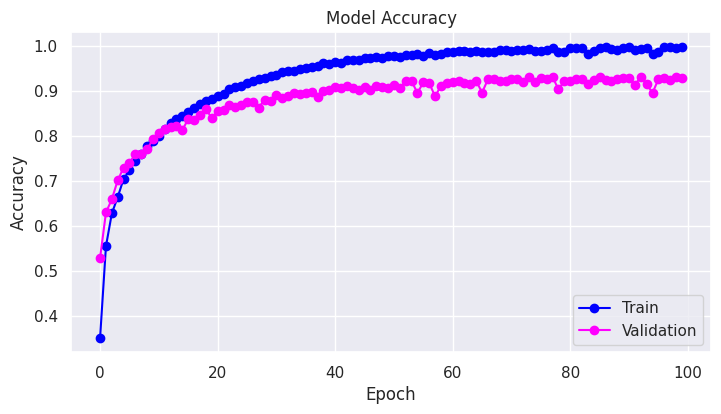

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG16_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(VGG16_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

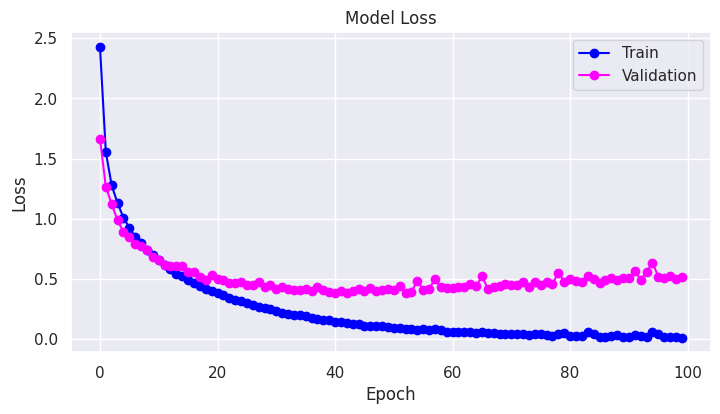

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG16_pretrained.history['loss'],'o-', color="blue")
plt.plot(VGG16_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
score = VGG16_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  93.077 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(VGG16_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 4s 16ms/step
[ 5  0  0 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[184,   0,   0, ...,   2,   0,   0],
       [  0, 189,   0, ...,   0,   0,   0],
       [  1,   1, 180, ...,   0,   0,   0],
       ...,
       [  2,   0,   0, ..., 170,   0,   0],
       [  0,   0,   0, ...,   0, 189,   6],
       [  0,   0,   0, ...,   0,   4, 179]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           4      0.898     0.920     0.909       200
          17      0.945     0.945     0.945       200
           9      0.900     0.900     0.900       200
           0      0.945     0.945     0.945       200
          35      0.928     0.965     0.946       200
           3      0.887     0.905     0.896       200
          10      0.887     0.940     0.913       200
          20      0.985     0.955     0.970       200
          32      0.984     0.930     0.956       200
           7      0.959     0.940     0.949       200
          24      0.926     0.940     0.933       200
          16      0.911     0.970     0.939       200
          14      0.924     0.910     0.917       200
           8      0.978     0.875     0.923       200
          33      0.884     0.915     0.899       200
          37      0.995     0.965     0.980       200
          34      0.985     0.955     0.970       200
          19      0.897    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

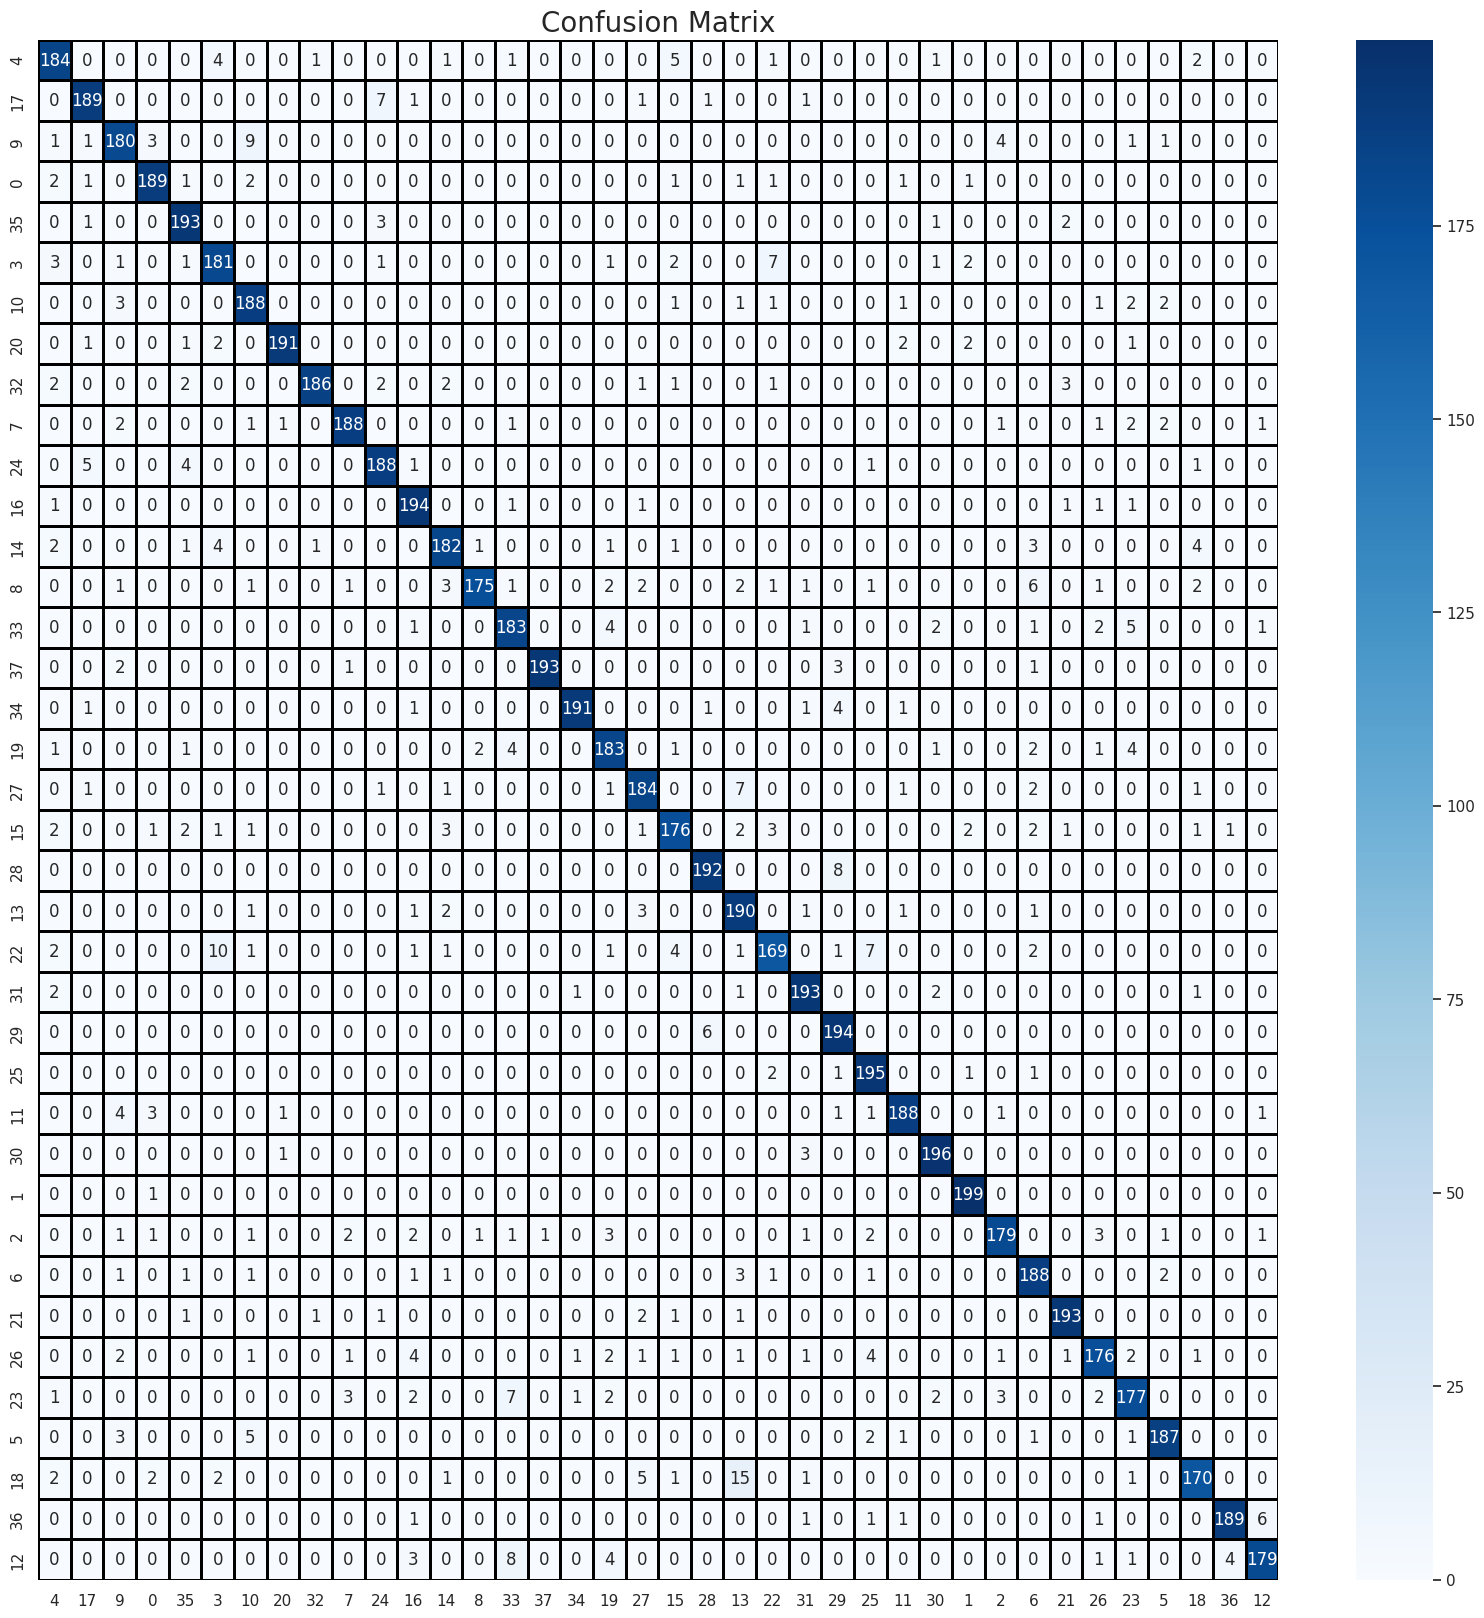

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

238/238 [==============================] - 4s 18ms/step


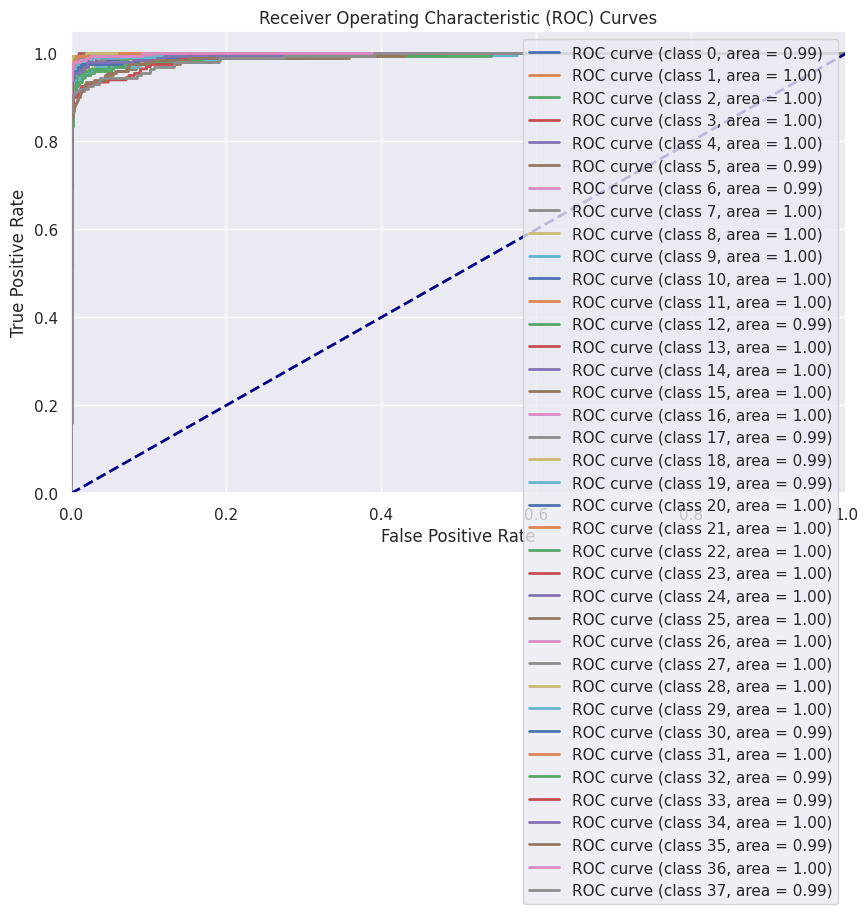

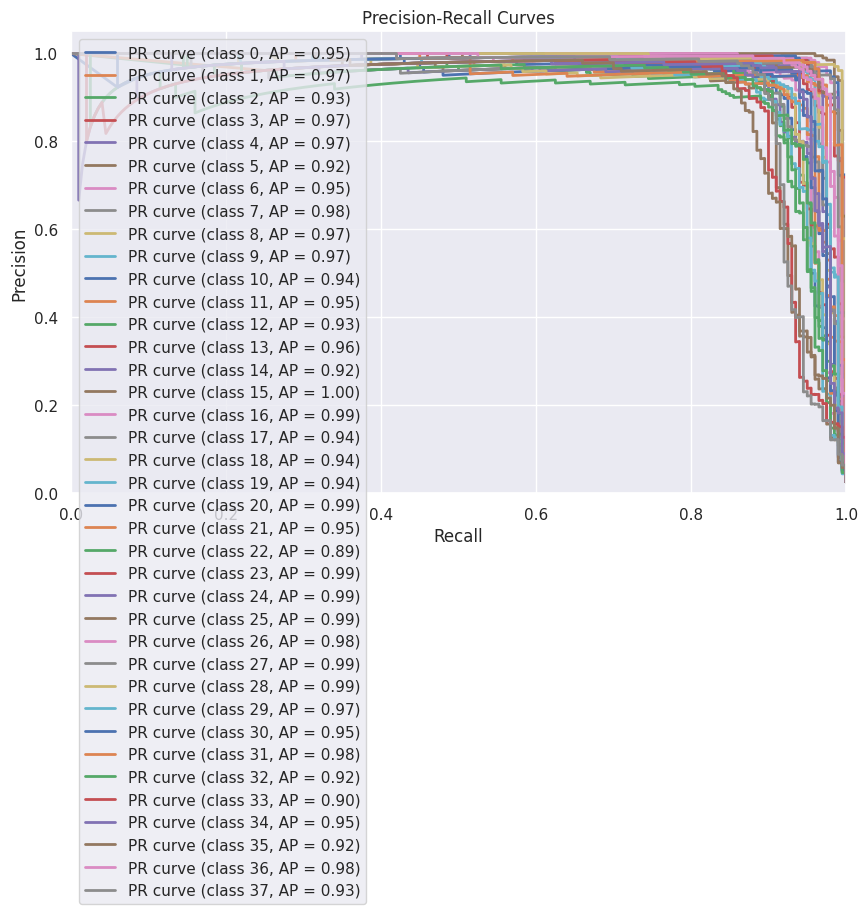

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = VGG16_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()

### Inceptionv3

In [22]:
import tensorflow as tf

# Load InceptionV3 model without the top (classification) layers
inception = tf.keras.applications.InceptionV3(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'  # Use 'None' to load without pre-trained weights
)

# Freeze the base InceptionV3 layers
inception.trainable = False

# Create your custom classification head
x = tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Dense(8, activation='softmax')(x)

# Combine the base InceptionV3 model with the custom head
inception_model = tf.keras.Model(inputs=inception.input, outputs=y)

# Compile the model
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:

inceptionv3 = inception_model.fit(
    x=X_train,
    y=Y_train,
    epochs=100,
    validation_data=(X_test, Y_test),
    batch_size=96
)


Epoch 1/100


ValueError: ignored